In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")
data

<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
Attributes:
    file_name:  ..\data\Bz_uc0.mat

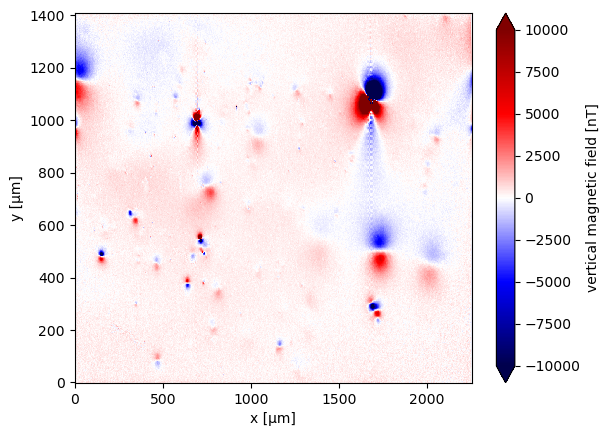

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Polynomial fitting to suppress high frequency noise
2. Upward continue the data to suppress high frequency noise
3. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
4. Contrast stretch the TGA to highlight weaker sources
5. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Polynomial fitting to suppress low frequency noise

In [4]:
table = vd.grid_to_table(data)

In [5]:
trend = vd.Trend(degree=3).fit((table.x, table.y), table.bz)
low_frequency_noise = trend.grid(
    coordinates=(data.x, data.y),
    dims=("y", "x"),
)
data = data.assign(low_freq=low_frequency_noise.scalars)
data.low_freq.attrs = {"long_name": "low-frequency noise", "units": "nT"}
data = data.assign(residual=data.bz - data.low_freq)
data.residual.attrs = {"long_name": "residual anomaly", "units": "nT"}
data

<xarray.Dataset>
Dimensions:   (y: 600, x: 960)
Coordinates:
  * x         (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y         (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z         (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz        (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
    low_freq  (y, x) float64 -158.8 -156.5 -154.1 -151.7 ... 506.6 508.7 510.8
    residual  (y, x) float64 511.2 251.3 195.7 440.1 ... -510.8 -562.2 -508.7
Attributes:
    file_name:  ..\data\Bz_uc0.mat

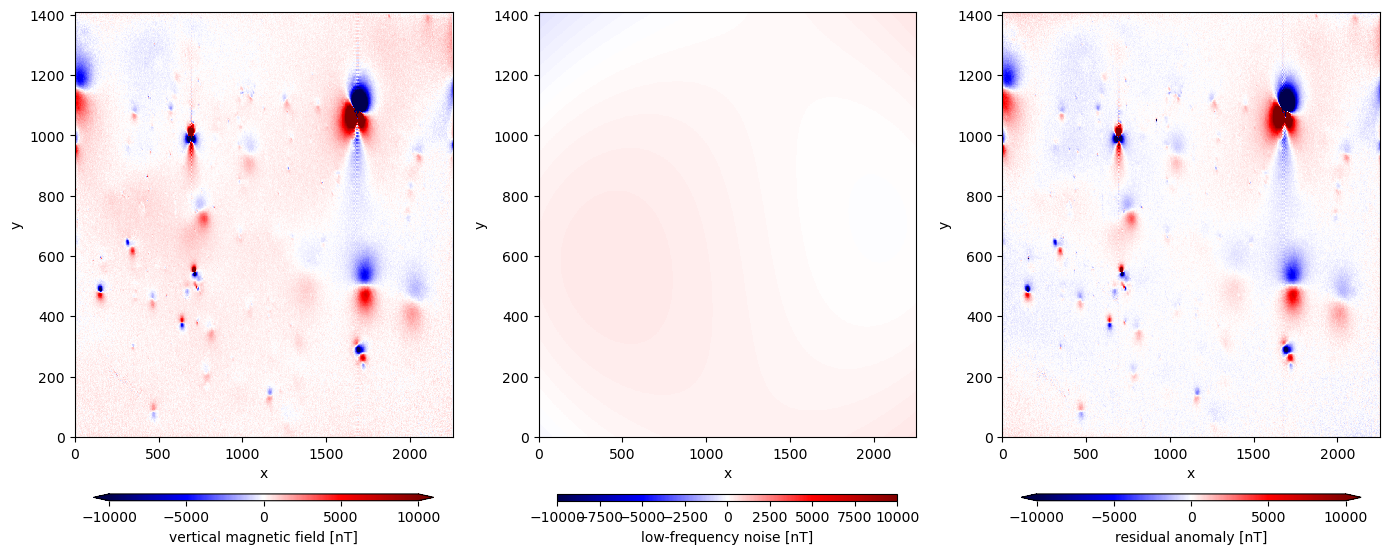

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "low_freq", "residual"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
plt.tight_layout()

## 2. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [93]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.residual, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43

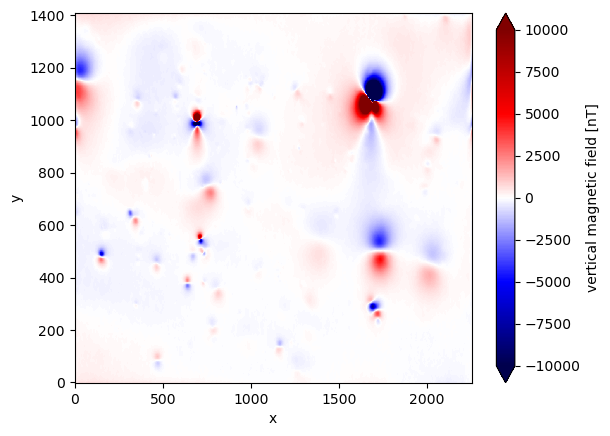

In [94]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 3. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [95]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 179.4 272.2 330.3 374.5 ... -37.43 2.523 81.43
    tga      (y, x) float64 41.31 39.91 30.8 31.58 ... 47.0 48.39 53.51 45.85
    x_deriv  (y, x) float64 39.52 32.11 21.76 16.75 ... 10.44 14.16 25.29 33.58
    y_deriv  (y, x) float64 -7.62 -9.232 -12.67 -16.62 ... -20.44 -16.89 -9.813
    z_deriv  (y, x) float64 -9.317 -21.84 -17.73 -20.98 ... 41.51 44.03 29.64

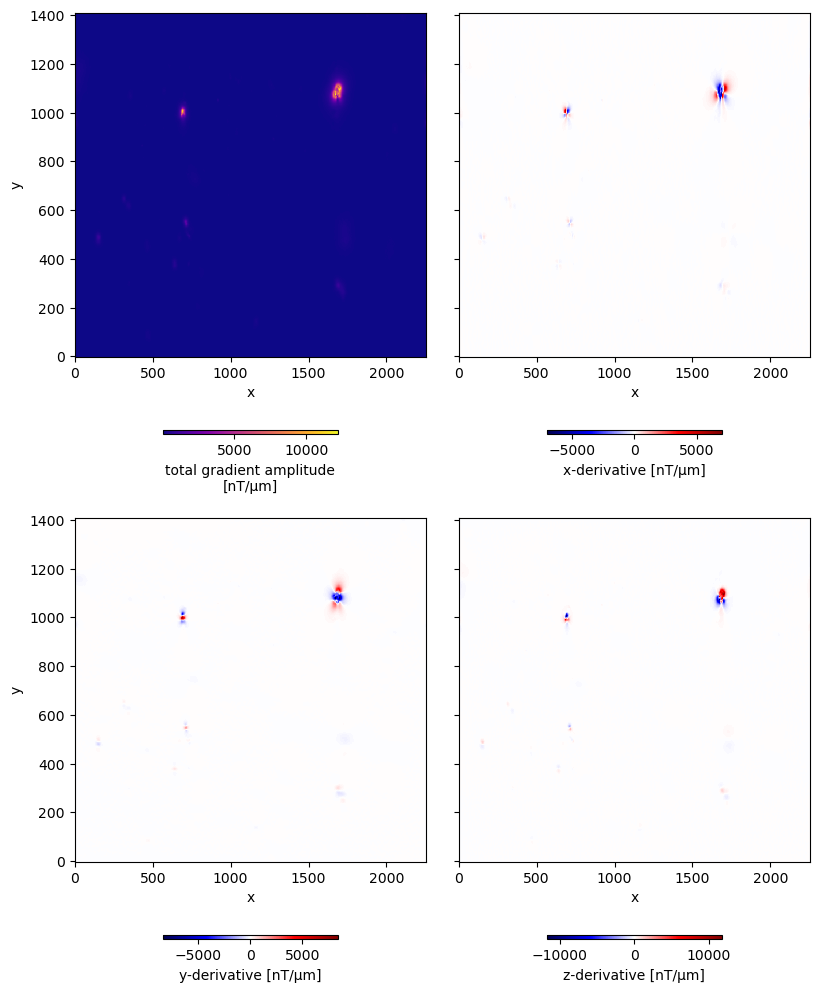

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [334]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

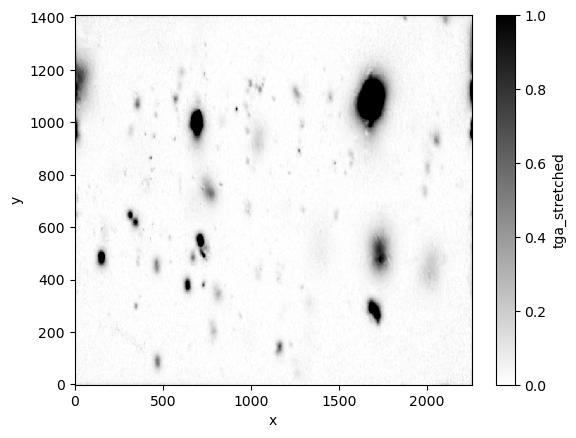

In [335]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 5. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [338]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.25,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  103


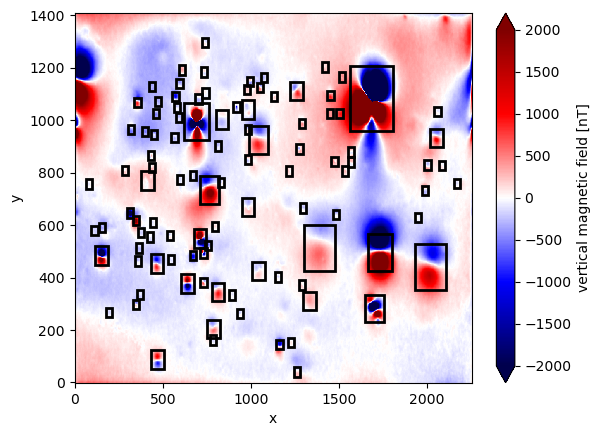

In [339]:
ax = plt.subplot(111)
scale = 2000
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [492]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0
#     poor_fit = False
    poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
    print("R²: %s"%r2)  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.8879474454686606
R²: 0.9183883204054434
R²: 0.9948586689226661
R²: 0.9729155534203098
R²: 0.997238167176092
R²: 0.9813627301403229
R²: 0.9856082231719456
R²: 0.9992258795137124
R²: 0.996239833881377
R²: 0.960407177696883
R²: 0.9980080257589974
R²: 0.9961228684766801
R²: 0.9485383246324557
R²: 0.9934869972882768
R²: 0.9465222242261253
R²: 0.9788424031522388
R²: 0.9688560734489219
R²: 0.9658474884092412
R²: 0.9841432232156462
R²: 0.9395152250007578
R²: 0.9630125531290955
R²: 0.9758768768820153
R²: 0.9575173587530521
R²: 0.9544262685361521
R²: 0.9951668201642417
R²: 0.9421168645192863
R²: 0.9126080095618914
R²: 0.9049437135827305
R²: 0.9704457894767685
R²: 0.9591529448494285
R²: 0.986396990016353
R²: 0.9721107597564987
R²: 0.9915753986088928
R²: 0.9528770877714556
R²: 0.8854378650924319
R²: 0.9525581251087072
R²: 0.8641819395580647
R²: 0.886577419185761
R²: 0.8630725730594319
R²: 0.9316924557746201
R²: 0.9653688955326999
R²: 0.9240383133497732
R²: 0.9808964389125445
R²: 0.9227599048

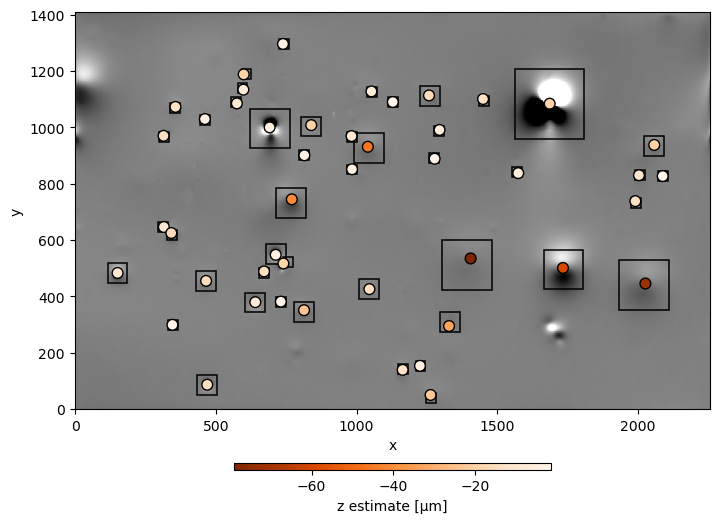

In [488]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="Oranges_r", s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

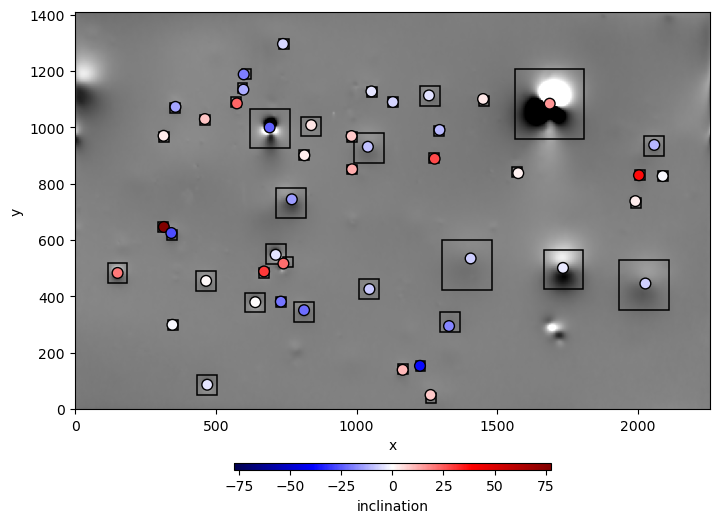

In [489]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

estimated = mg.vector_to_angles(estimated_dipole_moments)
scale = vd.maxabs(estimated[0])
tmp = ax.scatter(*positions[:2], c=estimated[0], cmap="seismic", vmin=-scale, vmax=scale, s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="inclination")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

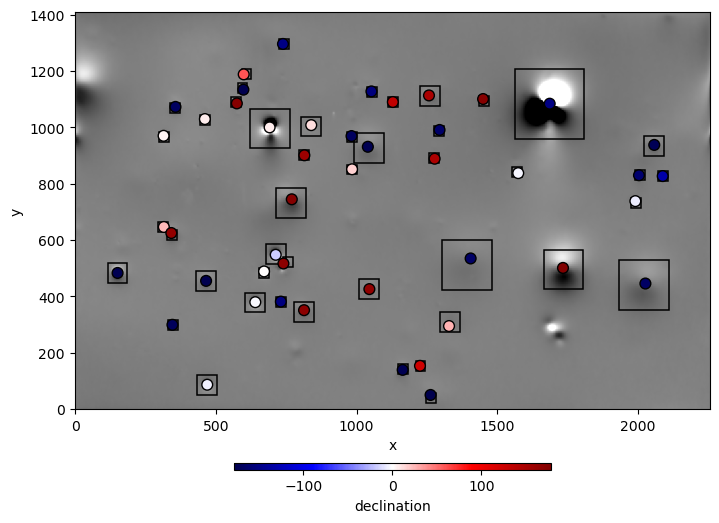

In [490]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

estimated = mg.vector_to_angles(estimated_dipole_moments)
scale = vd.maxabs(estimated[1])
tmp = ax.scatter(*positions[:2], c=estimated[1], cmap="seismic", vmin=-scale, vmax=scale, s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="declination")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

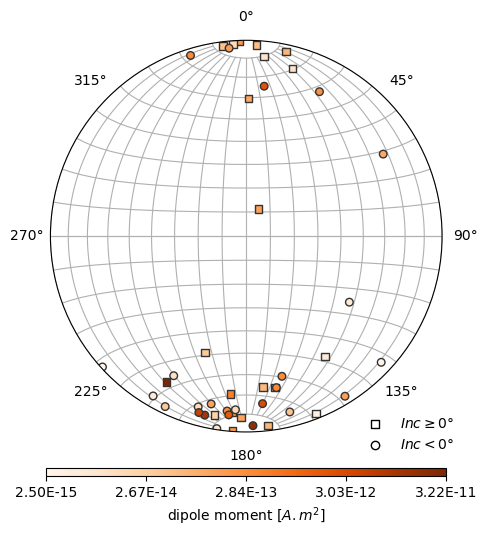

In [491]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2E}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

R²: 0.8877321976701348  | Dec: -151.2788903546959 | Inc: 16.307639869431412 | Amp: 3.2226761167438913e-11
SNR: 9.52157162510858 |  Xc: 1685.465503422801 |  Yc: 1084.3960749053647 |  Zc: -20.176664688520713


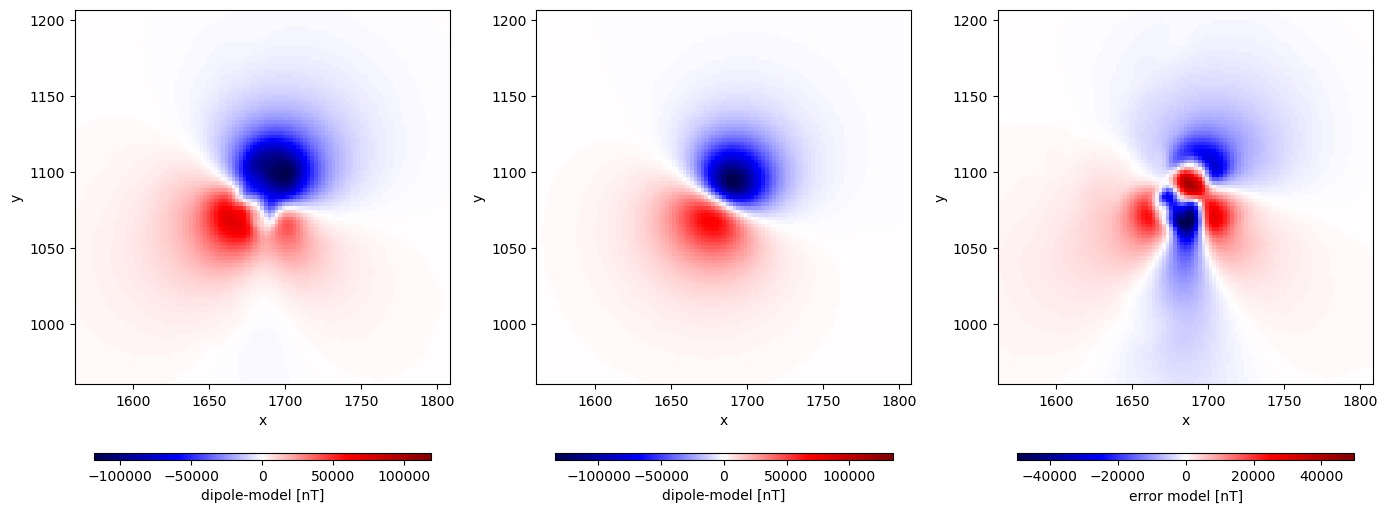

R²: 0.9155827126758505  | Dec: 6.814333236069007 | Inc: -24.012251577716356 | Amp: 2.0185118310523593e-12
SNR: 10.993635964000406 |  Xc: 690.8394075628041 |  Yc: 1000.3262318230373 |  Zc: -5.929890017408035


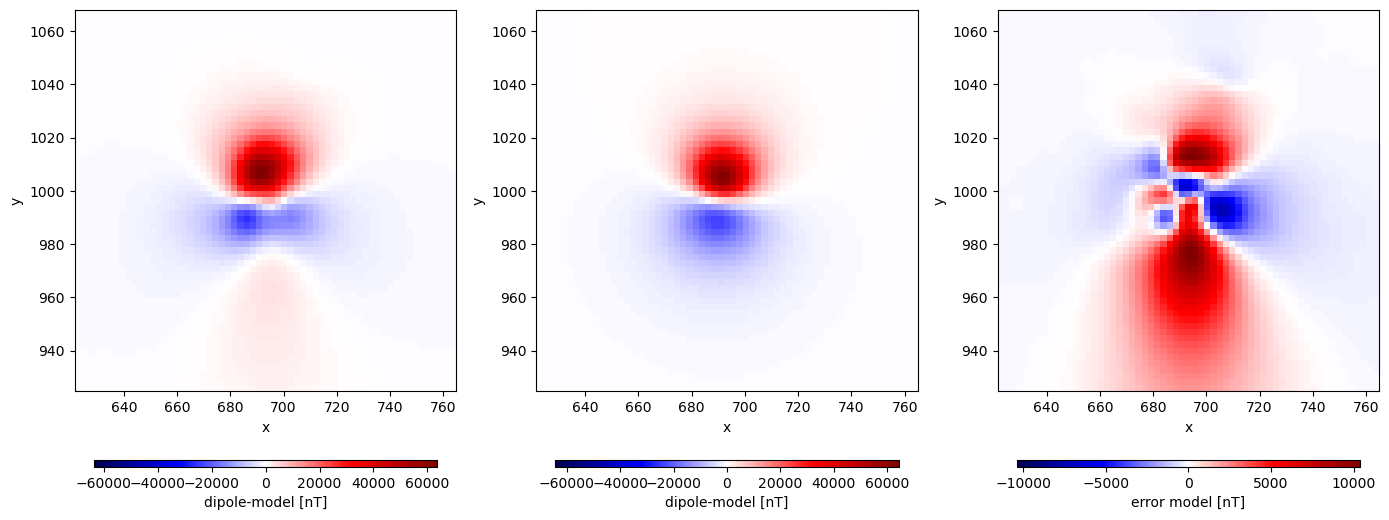

R²: 0.9874817164516164  | Dec: -174.30507118414698 | Inc: 22.018000666298793 | Amp: 4.3585335323421583e-13
SNR: 22.223030993912882 |  Xc: 150.86792318295153 |  Yc: 483.39959826122845 |  Zc: -9.937156621730995


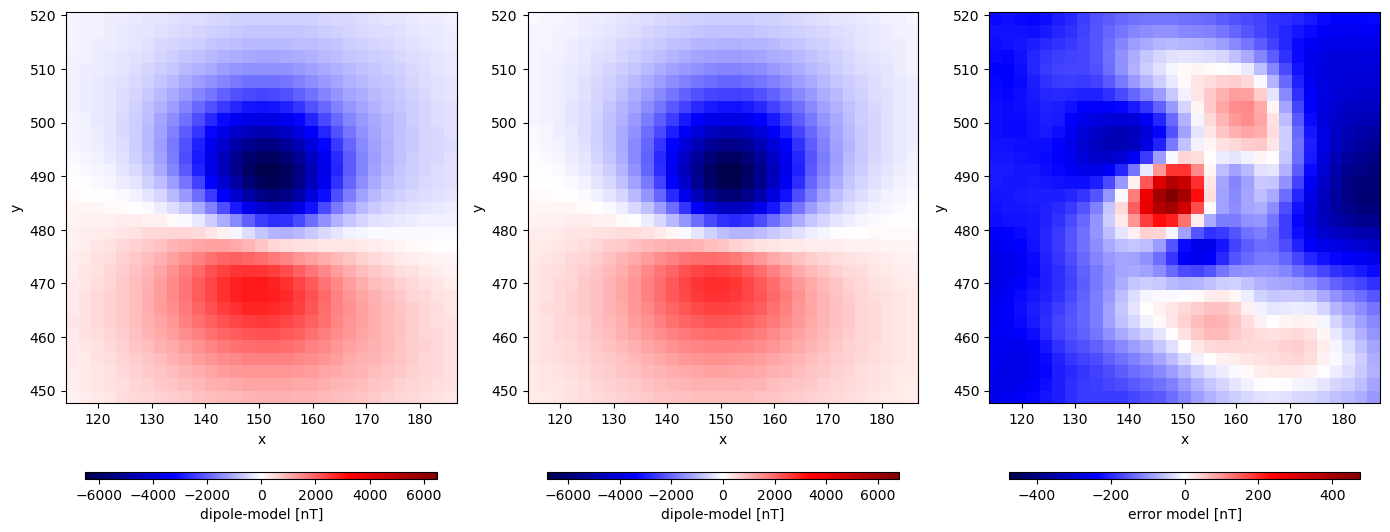

R²: 0.9716861124634816  | Dec: -17.146102771545518 | Inc: -4.305759017717285 | Amp: 3.026544975815681e-13
SNR: 15.666613784194293 |  Xc: 712.4652639435027 |  Yc: 547.768200015255 |  Zc: -4.437487204372263


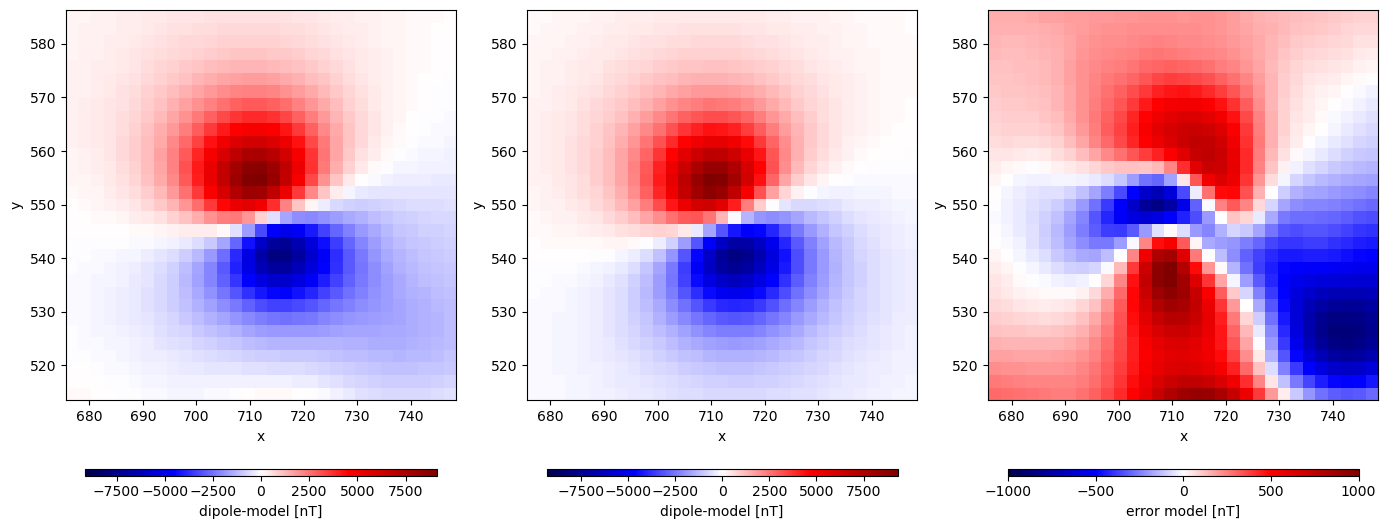

R²: 0.9910744084150757  | Dec: -1.9306822647368729 | Inc: 1.8509229402145162 | Amp: 1.9866065092046548e-13
SNR: 24.47783279094804 |  Xc: 639.9541482517126 |  Yc: 379.49182945573335 |  Zc: -8.650535380992523


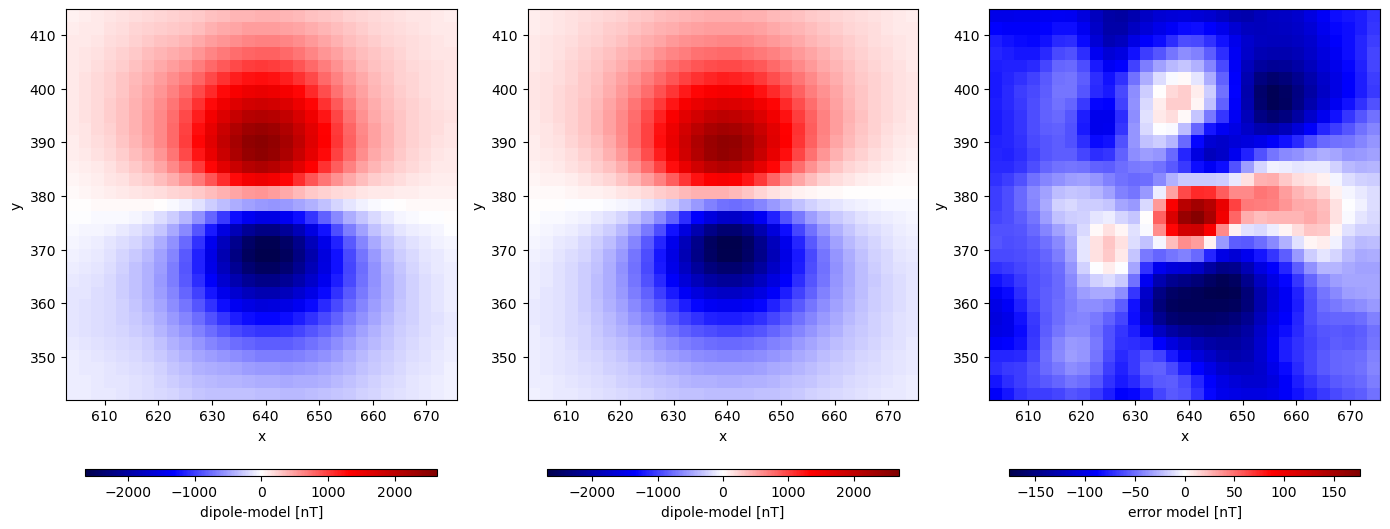

R²: 0.9780899608078948  | Dec: 25.39069264439025 | Inc: 77.83814441293417 | Amp: 1.3665023187941105e-13
SNR: 16.968493130983592 |  Xc: 315.1125069728443 |  Yc: 646.6043643176338 |  Zc: -9.966997754629434


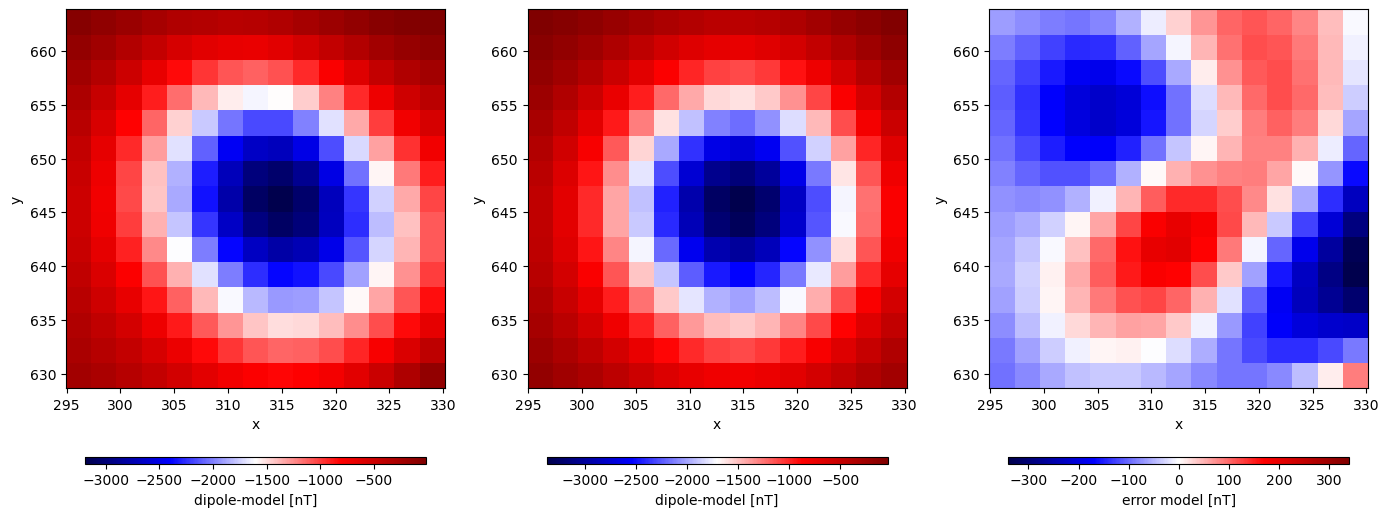

R²: 0.9818913112139003  | Dec: 166.31014787024398 | Inc: -25.346647758932864 | Amp: 2.779101851274446e-13
SNR: 17.588546987648186 |  Xc: 341.79395956621295 |  Yc: 625.1476941847627 |  Zc: -15.339344967177155


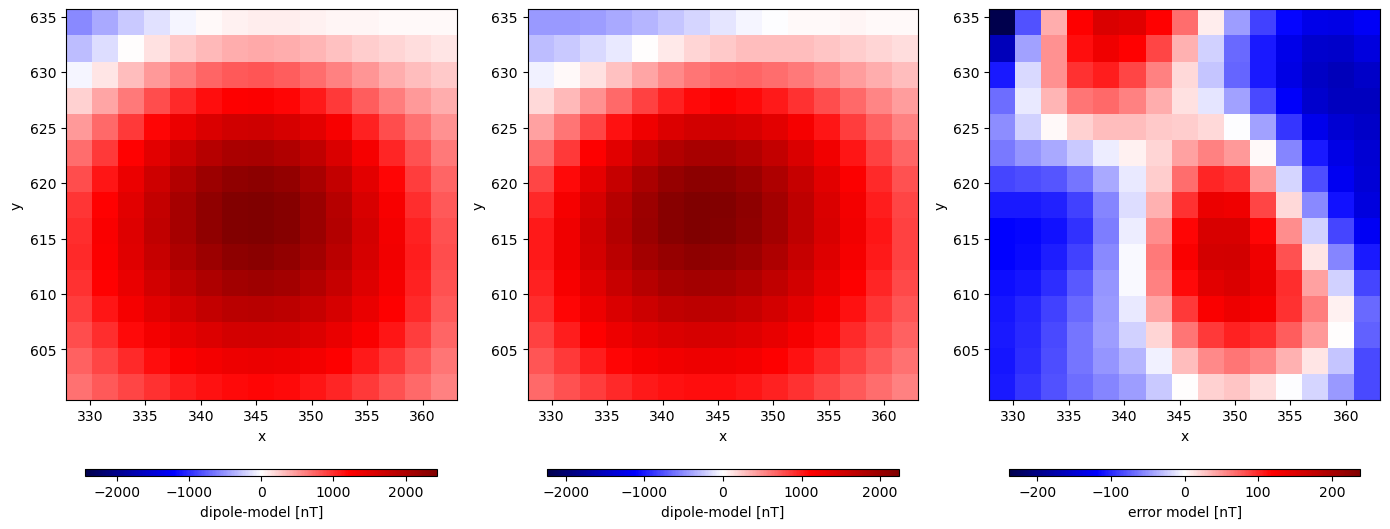

R²: 0.9969253340243982  | Dec: 178.01341719336352 | Inc: -2.0800237294711073 | Amp: 1.7753619220499438e-11
SNR: 27.037552915473203 |  Xc: 1732.7098509531882 |  Yc: 501.14917209241963 |  Zc: -59.441661911007635


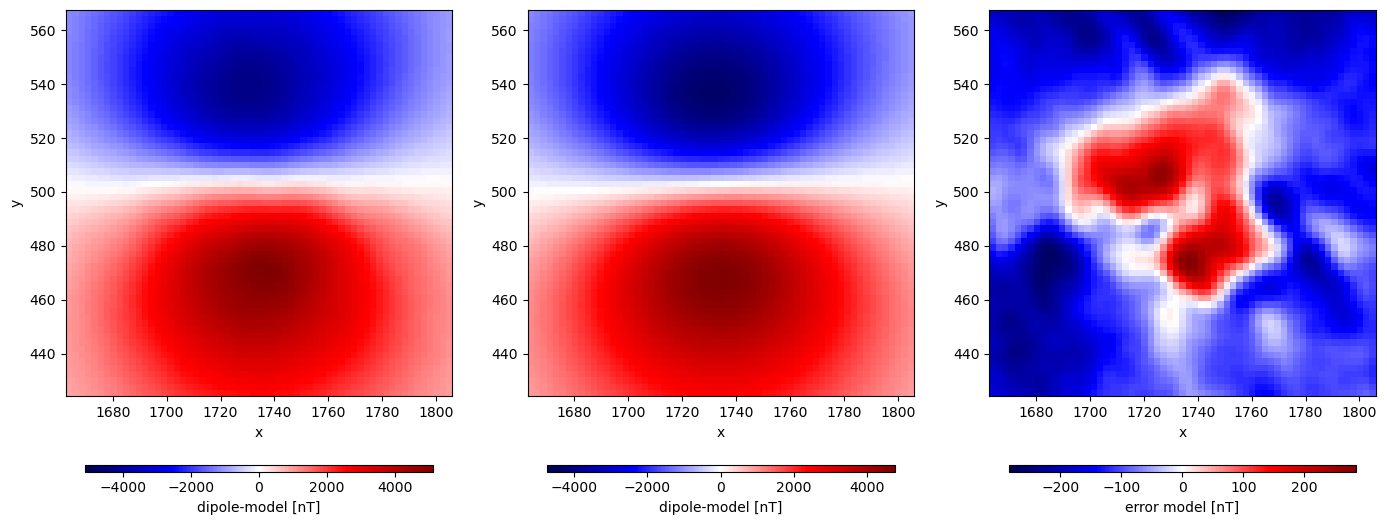

R²: 0.9939396085895169  | Dec: -175.41135204669925 | Inc: 12.684820988358553 | Amp: 1.5337881392391713e-13
SNR: 22.600037391665925 |  Xc: 1163.3717624666747 |  Yc: 139.17725368726323 |  Zc: -12.509671318992863


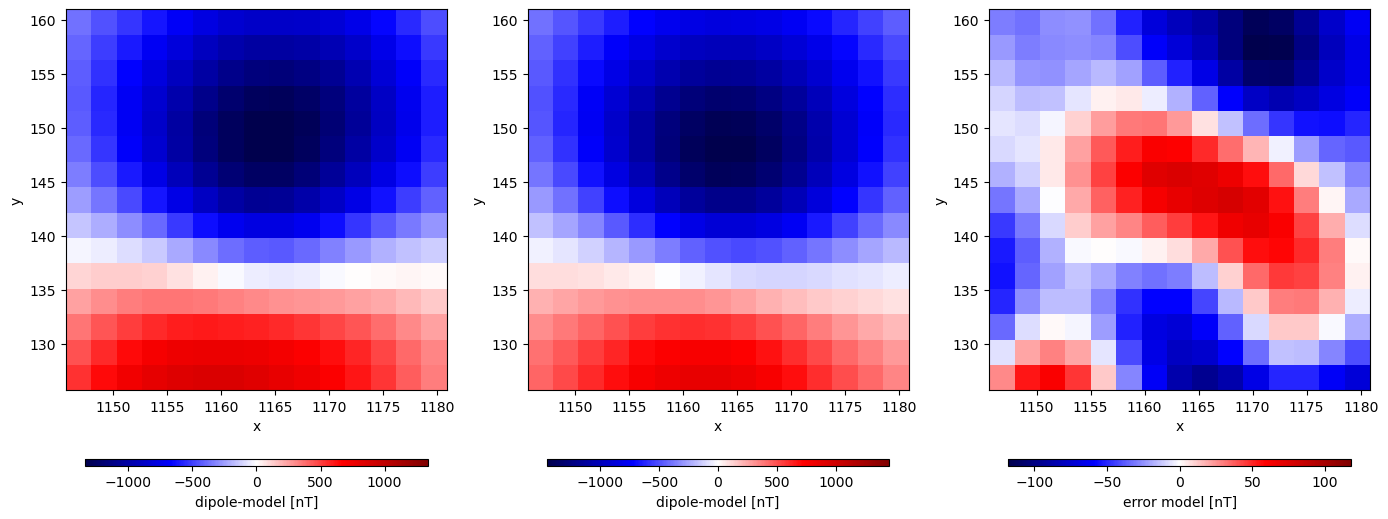

R²: 0.9549590980127147  | Dec: -152.42014307021822 | Inc: -18.107196924269616 | Amp: 1.1082816232822508e-14
SNR: 13.910533151702303 |  Xc: 730.6581538157683 |  Yc: 381.49967869305124 |  Zc: -2.30298319590133


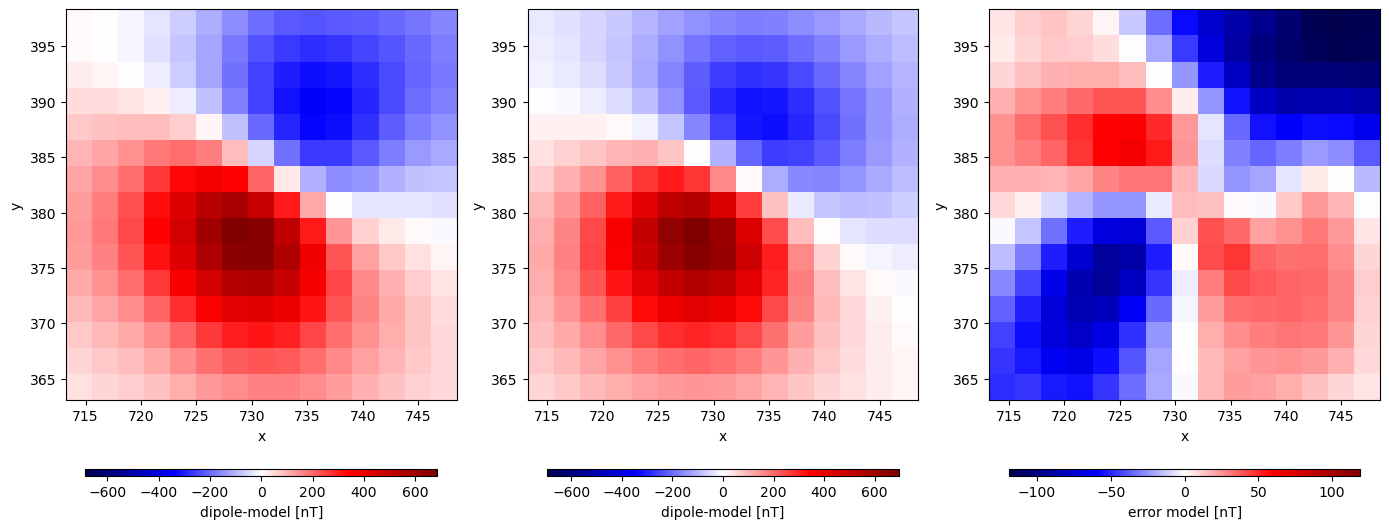

R²: 0.9571194138098926  | Dec: -168.92230362314478 | Inc: -3.577642799509601 | Amp: 1.1839446553046906e-13
SNR: 14.730921571785094 |  Xc: 356.4028079585462 |  Yc: 1073.0736382788855 |  Zc: -13.23873571914766


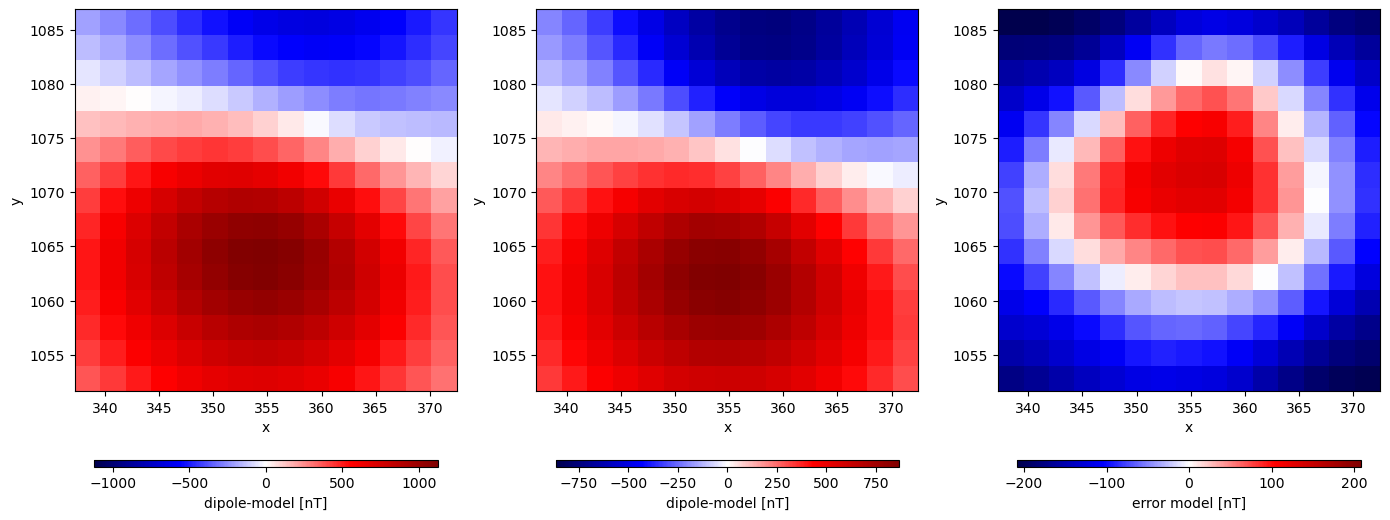

R²: 0.986514088858273  | Dec: -5.158238646781922 | Inc: -6.172065802760634 | Amp: 1.730118948540542e-13
SNR: 21.97994838097884 |  Xc: 469.2708099612267 |  Yc: 86.35809885667129 |  Zc: -14.268438873938127


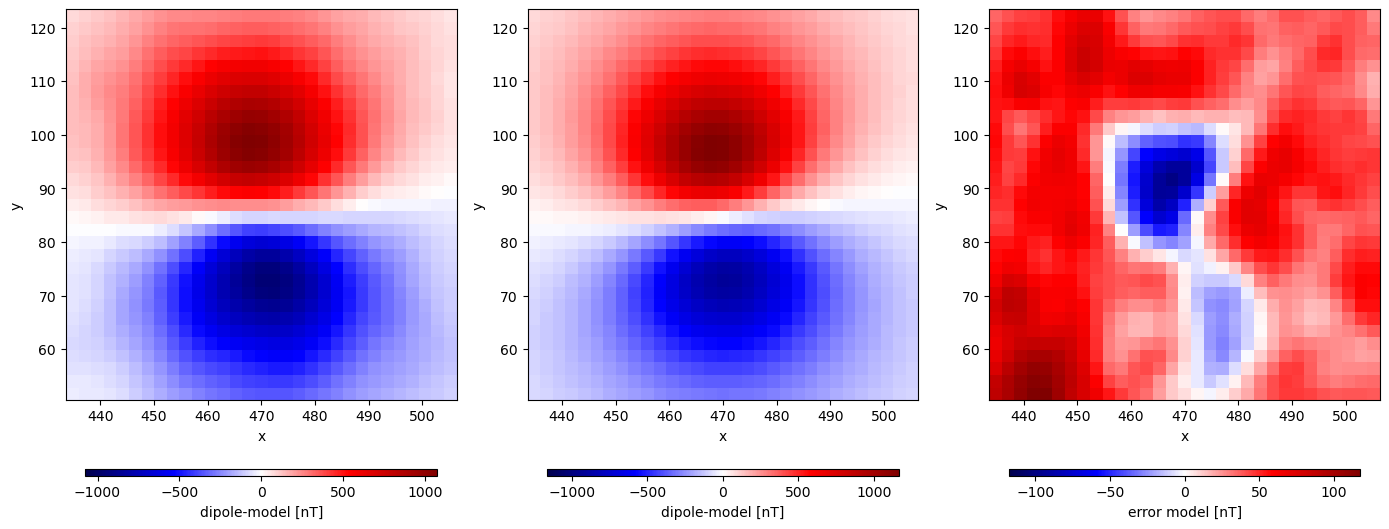

R²: 0.7501193358326511  | Dec: 170.2002640153437 | Inc: 31.918542102319446 | Amp: 6.948579913481087e-14
SNR: 7.415495240363694 |  Xc: 574.4088127246663 |  Yc: 1085.5317974385362 |  Zc: -9.534769769878249


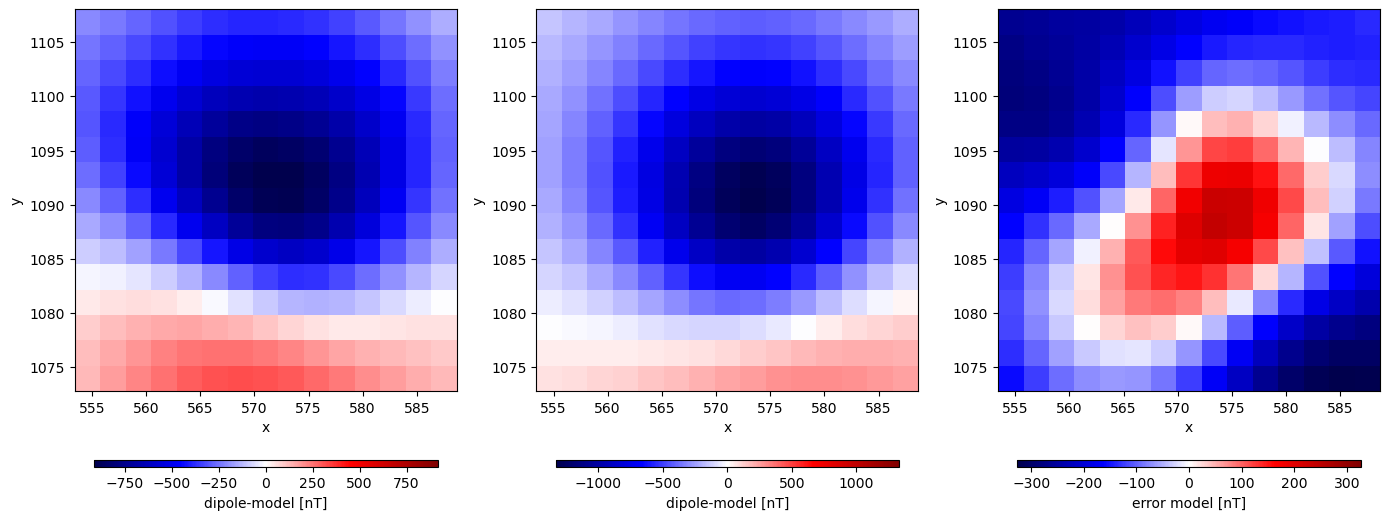

R²: 0.9827653200906772  | Dec: 1.4269941152326342 | Inc: 32.34195691785958 | Amp: 1.1475557864907979e-13
SNR: 18.348105847596017 |  Xc: 671.0989401803062 |  Yc: 488.655529016841 |  Zc: -13.56695712614255


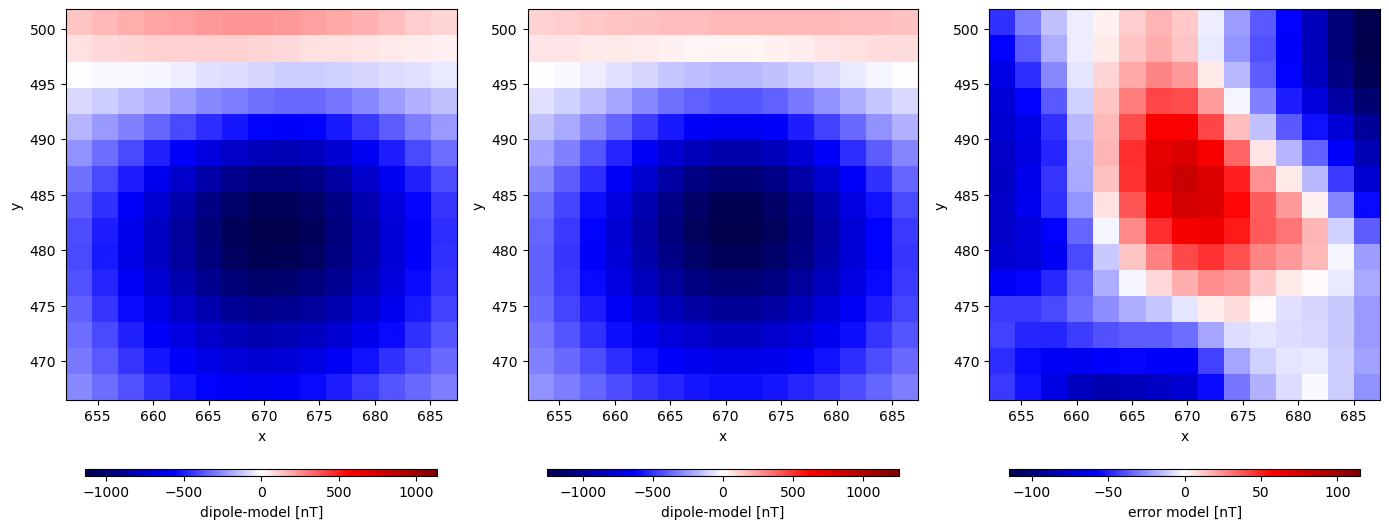

R²: 0.9406604051314132  | Dec: 174.77869507476413 | Inc: -17.2677612544732 | Amp: 2.7451274183400726e-12
SNR: 12.468756932342234 |  Xc: 769.5328187915804 |  Yc: 744.8495406254756 |  Zc: -40.69628631336016


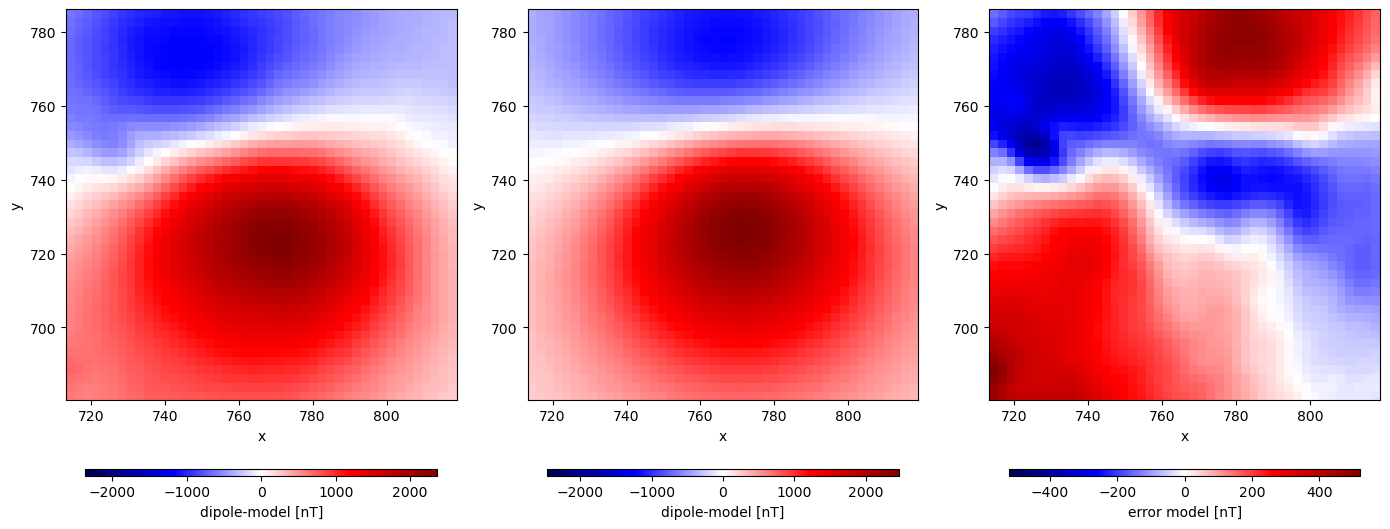

R²: 0.9117659155920901  | Dec: -175.87302316326594 | Inc: 6.910842147907987 | Amp: 1.9755533319969888e-13
SNR: 13.844444444385179 |  Xc: 465.19933697506093 |  Yc: 455.21917378759497 |  Zc: -15.693766101904126


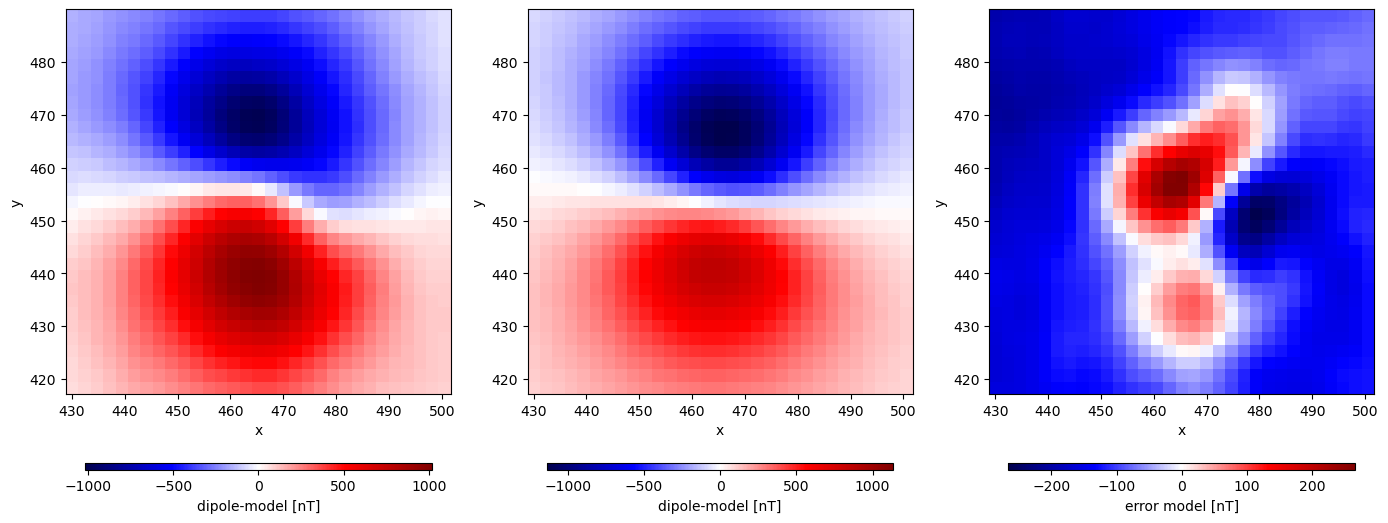

R²: 0.24338001213135563  | Dec: -168.2860292197837 | Inc: 17.606078918938167 | Amp: 7.407327596439178e-15
SNR: 6.760765094784712 |  Xc: 345.68284292233045 |  Yc: 299.1686797899842 |  Zc: -1.404022113235704


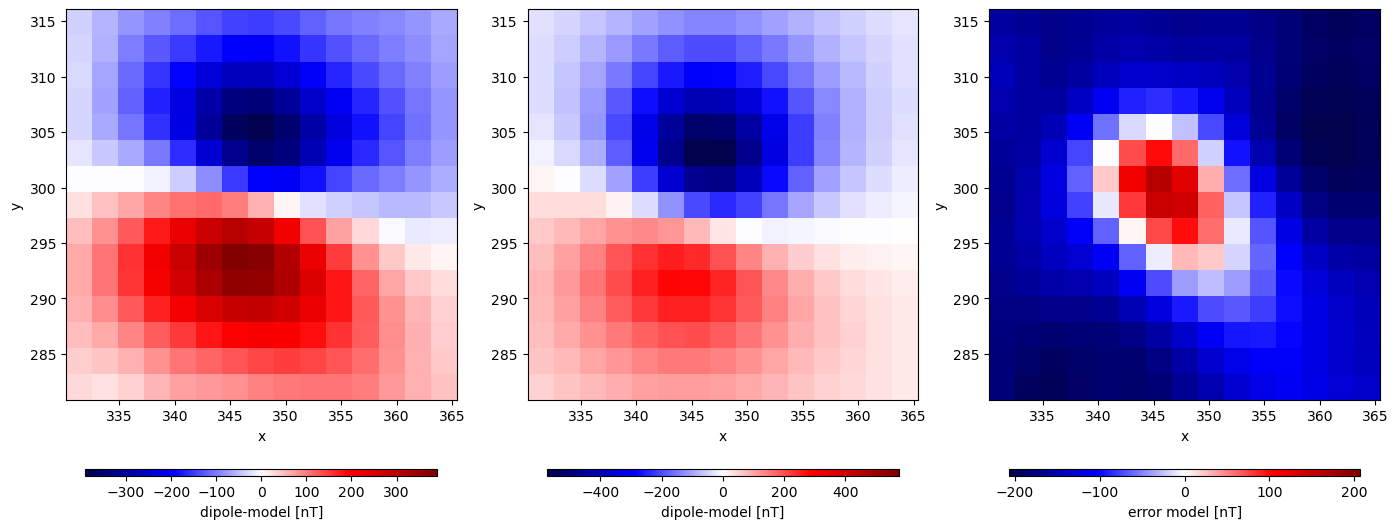

R²: 0.9684736172650077  | Dec: -154.30310165111436 | Inc: -1.9702218272211198 | Amp: 3.393954712040123e-14
SNR: 15.013262010336978 |  Xc: 1052.4408037918759 |  Yc: 1128.060018832059 |  Zc: -7.828072558448884


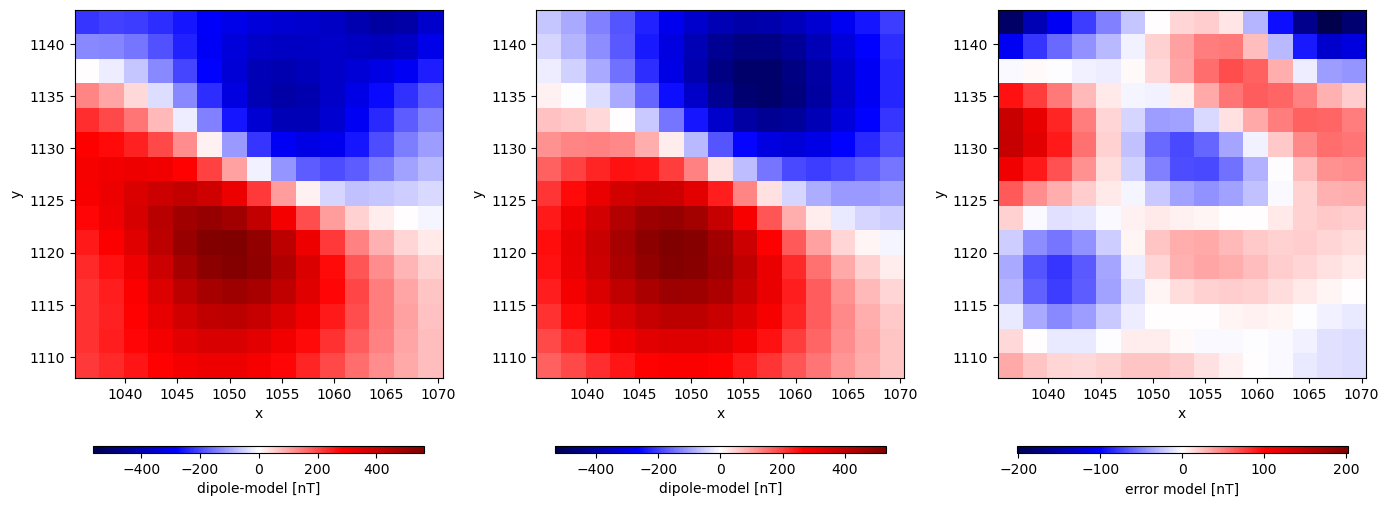

R²: 0.9860530026633865  | Dec: -173.74653506697348 | Inc: -12.495993014991276 | Amp: 2.786660874451169e-13
SNR: 18.555919448357926 |  Xc: 2056.81461561826 |  Yc: 938.0632657495711 |  Zc: -20.185656637023257


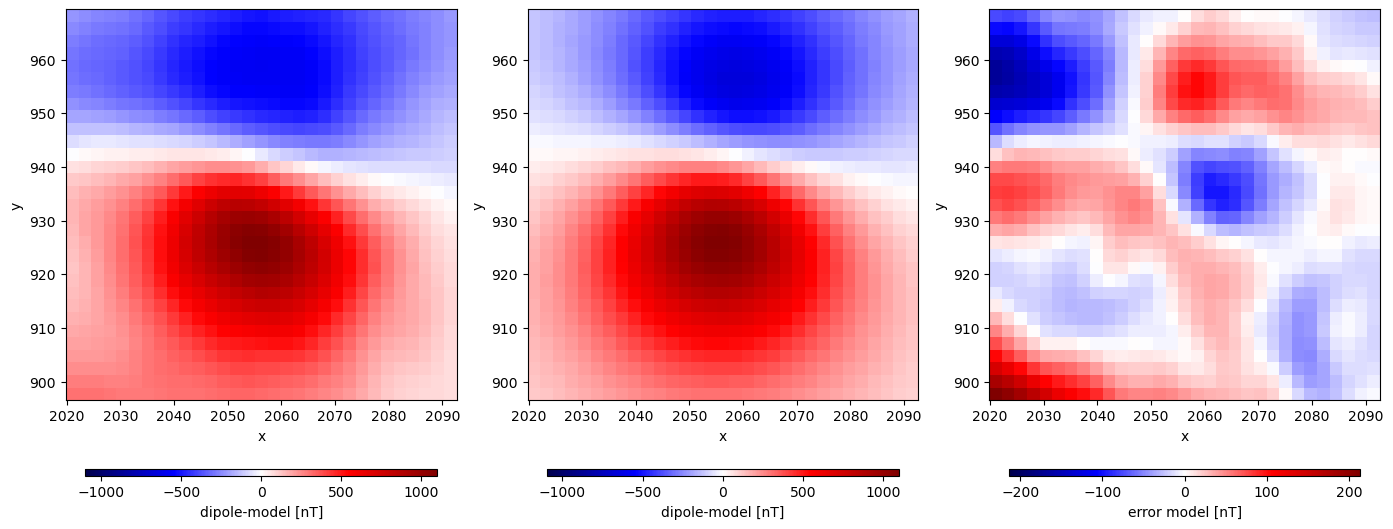

R²: -0.09577493740163168  | Dec: 146.24554046618903 | Inc: 2.3463552558614817 | Amp: 4.983768705665019e-15
SNR: 5.005188002867494 |  Xc: 1276.7987350222318 |  Yc: 889.0164073589617 |  Zc: -1.3671554372870105


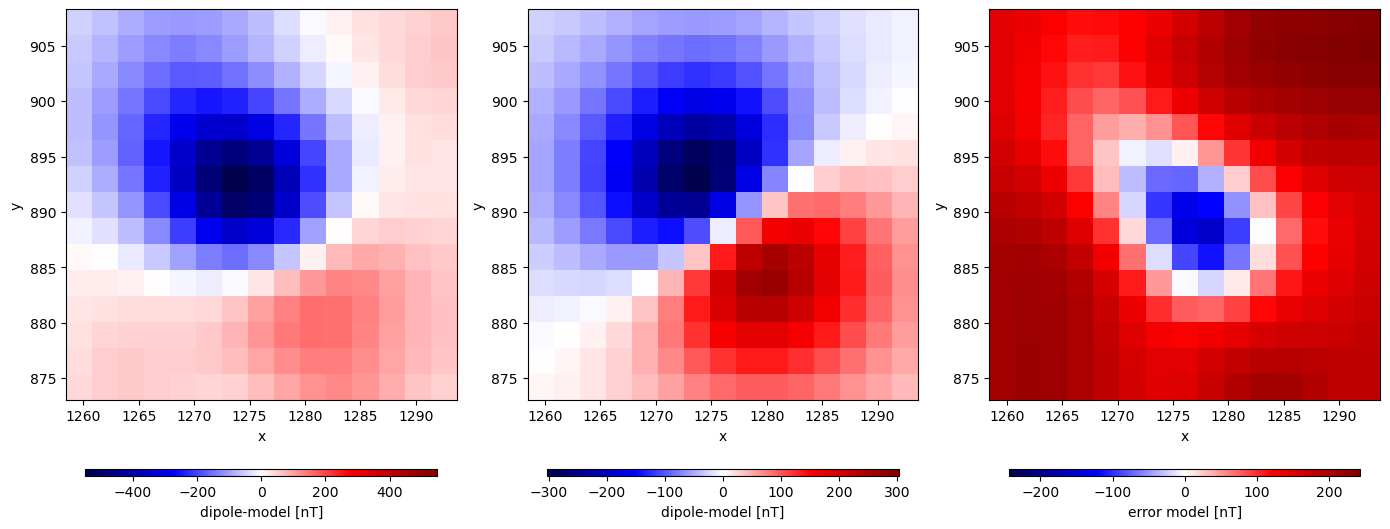

R²: 0.8789238814897526  | Dec: 148.03191139678202 | Inc: -11.158009520963281 | Amp: 1.5566071880168448e-13
SNR: 12.007761938338666 |  Xc: 1256.7964543187472 |  Yc: 1113.7925045361646 |  Zc: -16.120581726811483


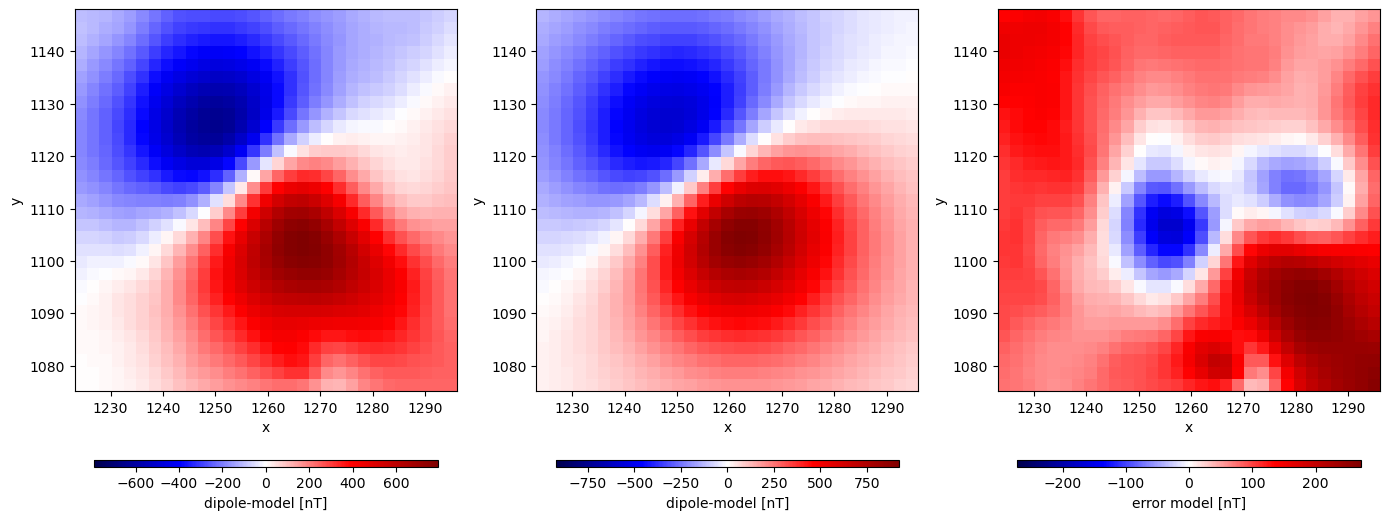

R²: 0.9729442919666831  | Dec: 168.79184932101063 | Inc: -22.93957851252757 | Amp: 3.1268250558759263e-13
SNR: 16.086185733480885 |  Xc: 813.0706940794234 |  Yc: 351.09516953418324 |  Zc: -24.17458999505708


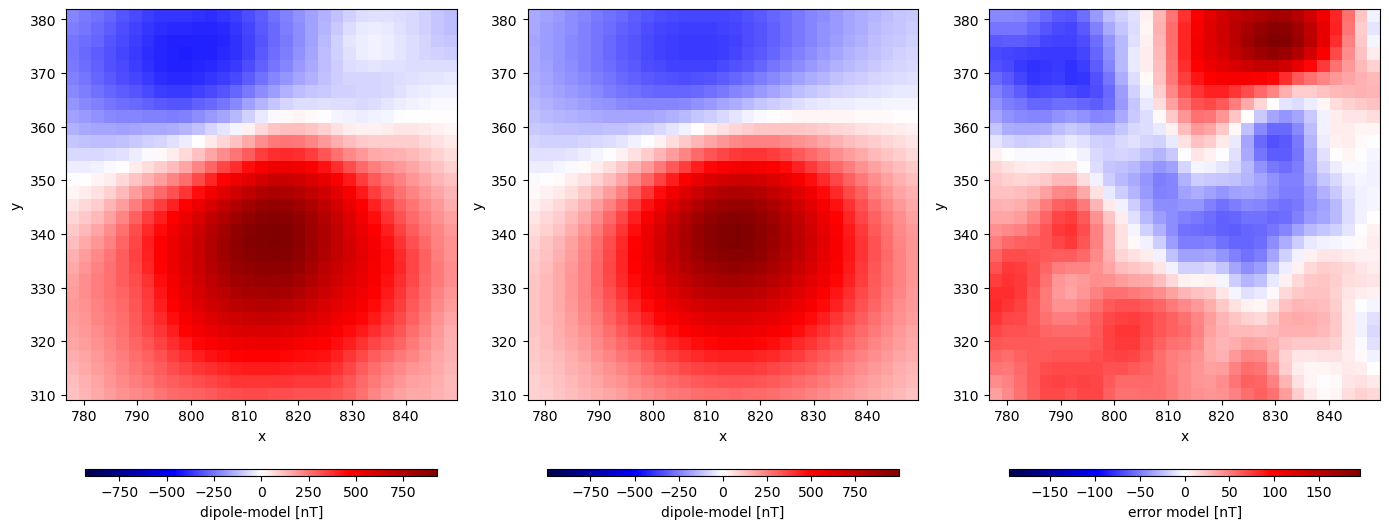

R²: 0.37456811248375155  | Dec: 167.0074868665555 | Inc: -22.078085276838607 | Amp: 9.956602375781765e-14
SNR: 3.053942696981407 |  Xc: 1448.939945201775 |  Yc: 1101.010332835227 |  Zc: -13.163680548760047


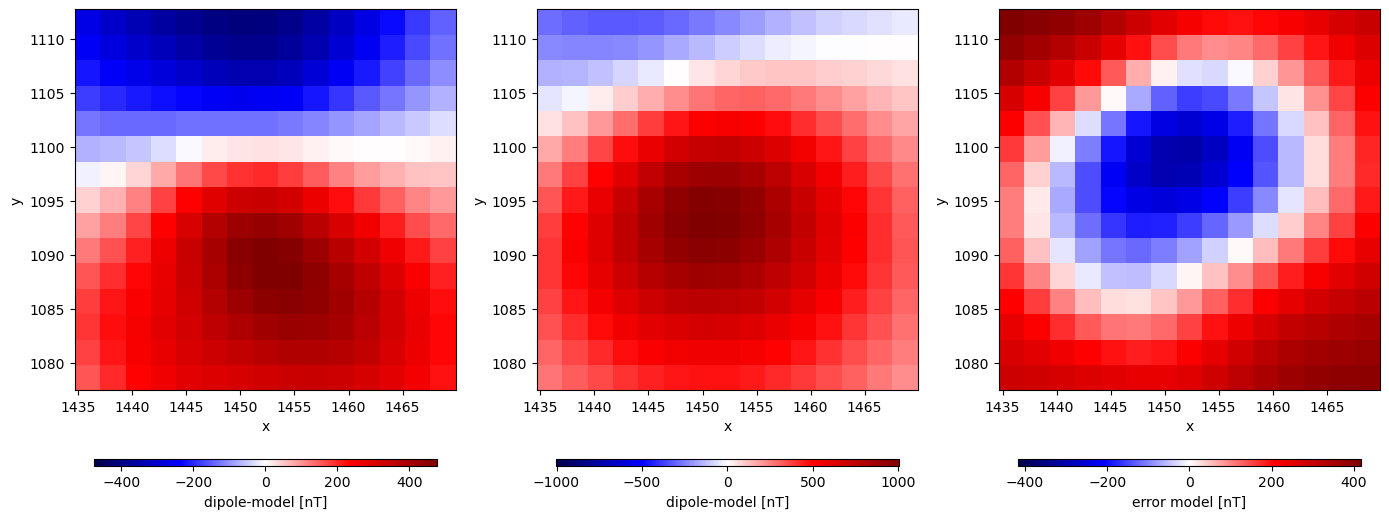

R²: 0.8838408527528097  | Dec: 14.586200581359853 | Inc: 2.305080775746577 | Amp: 8.931670692073134e-15
SNR: 11.200096600928468 |  Xc: 983.6224563180879 |  Yc: 851.5212946354046 |  Zc: -4.778861688771117


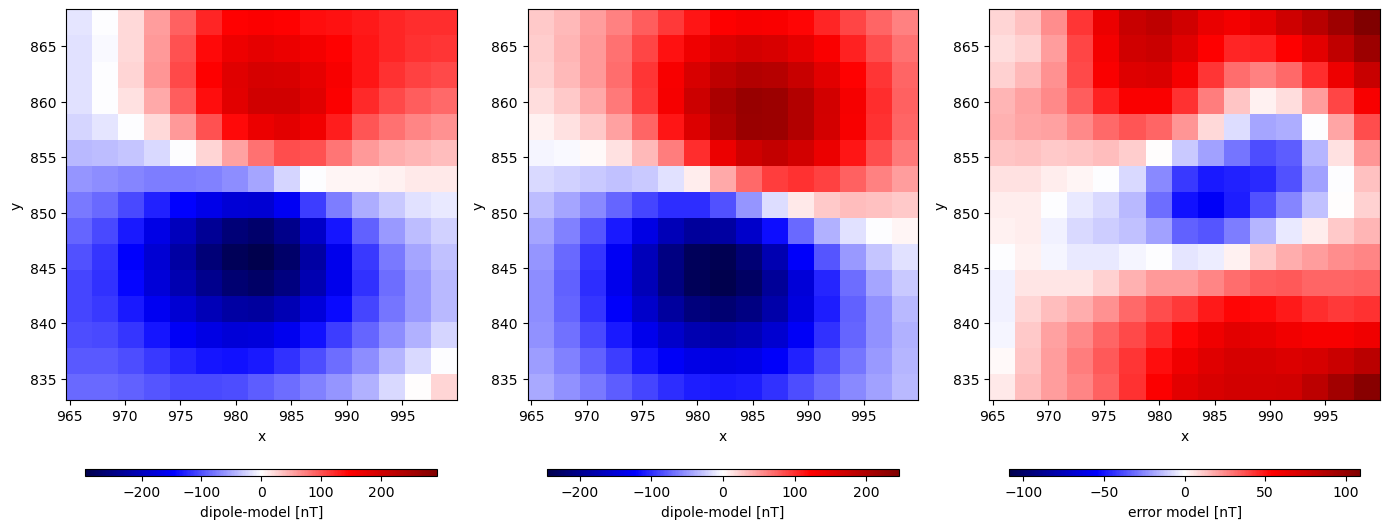

R²: 0.9924923320912851  | Dec: -166.8929020794996 | Inc: -8.043031518570945 | Amp: 8.99992895065031e-12
SNR: 22.28871635853856 |  Xc: 2025.3773158213216 |  Yc: 445.77707436867195 |  Zc: -72.36124740581045


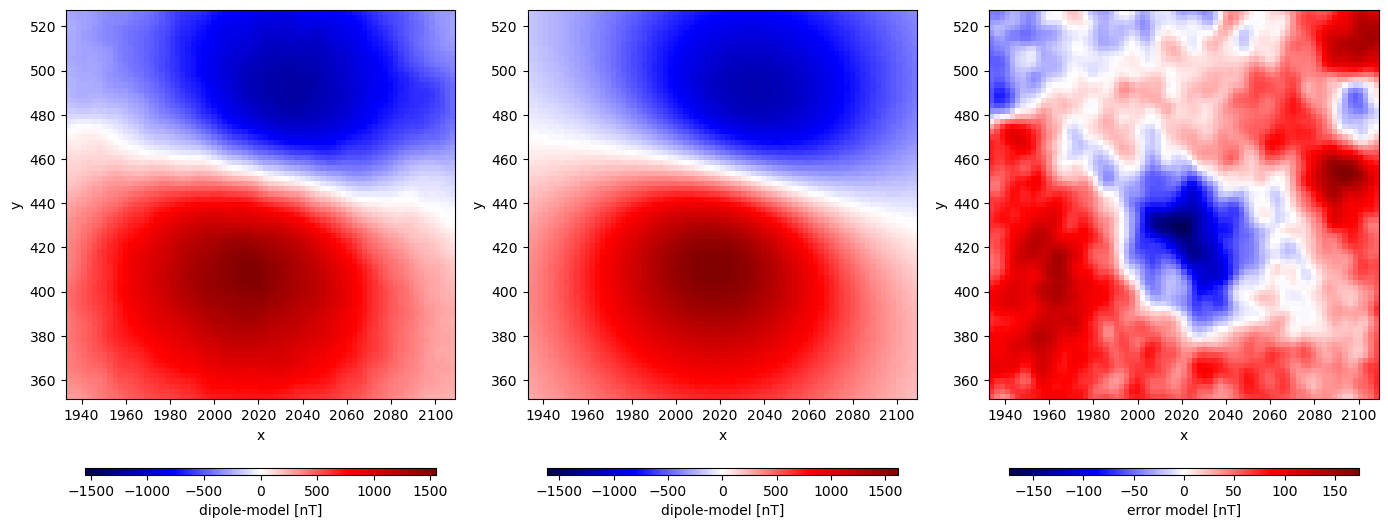

R²: 0.2569148725449234  | Dec: -163.23518357915958 | Inc: -29.36796929397238 | Amp: 1.7104425714154442e-14
SNR: 3.900757702045899 |  Xc: 1294.2569922682858 |  Yc: 991.1697313242444 |  Zc: -6.086697577358451


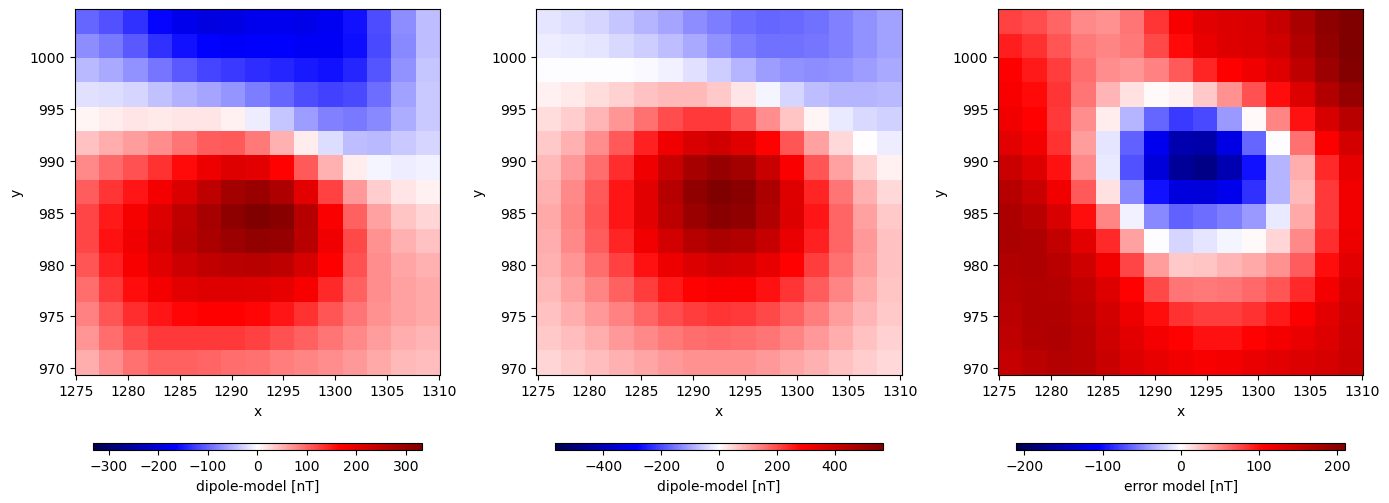

R²: 0.593556857828961  | Dec: -166.94668070463698 | Inc: 31.995642454581937 | Amp: 2.267784235286045e-14
SNR: 5.374478268334496 |  Xc: 981.6993291367792 |  Yc: 969.4687696838224 |  Zc: -9.097141507817023


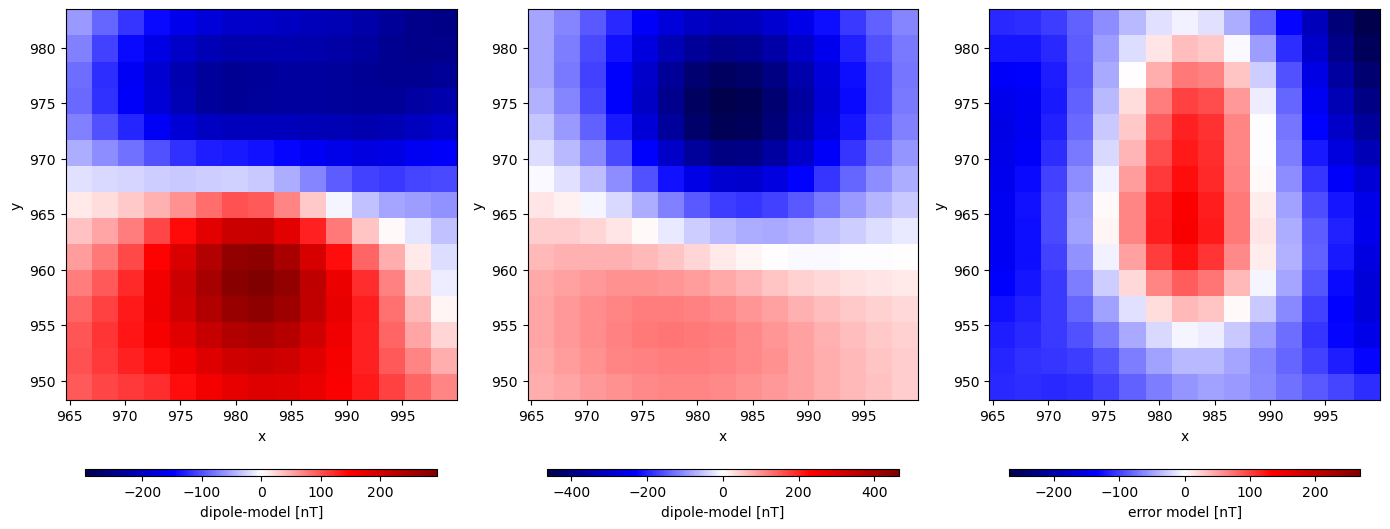

R²: 0.5521528683381596  | Dec: -167.519985685876 | Inc: 5.493815958831309 | Amp: 2.7857268603072393e-14
SNR: 4.577809729957549 |  Xc: 2002.6301914172777 |  Yc: 830.3585304566308 |  Zc: -11.379012891157553


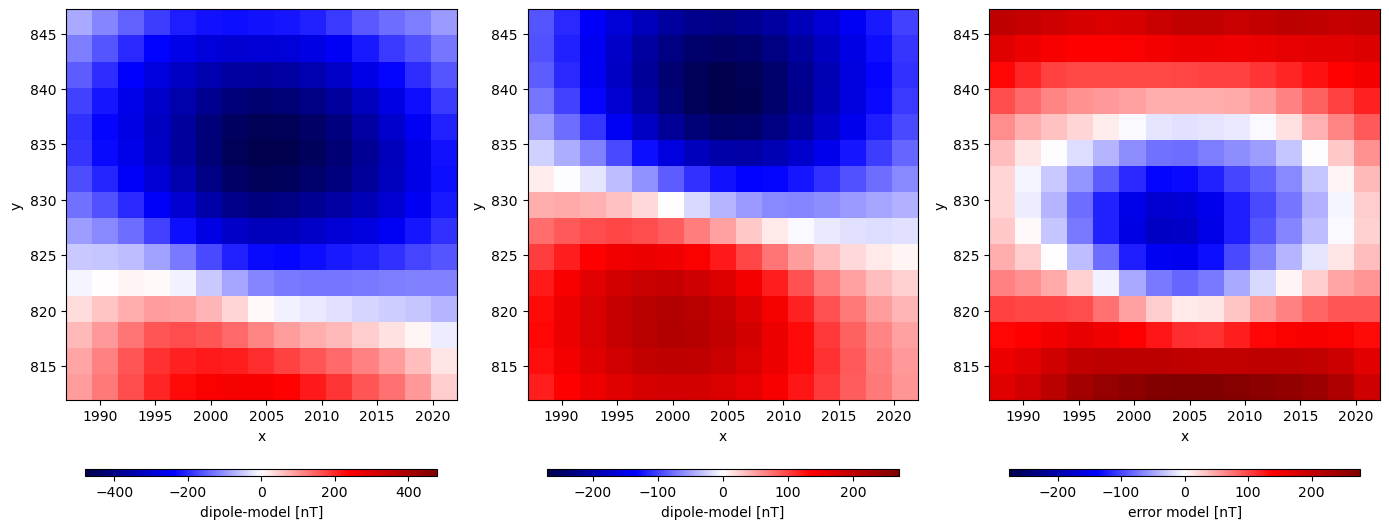

R²: -3.9378178841457236  | Dec: 5.630898568995853 | Inc: 46.09957255413319 | Amp: 1.4903597594359106e-14
SNR: -3.4135870533494064 |  Xc: 460.87781579291845 |  Yc: 1029.8544471564087 |  Zc: -4.860466827428534


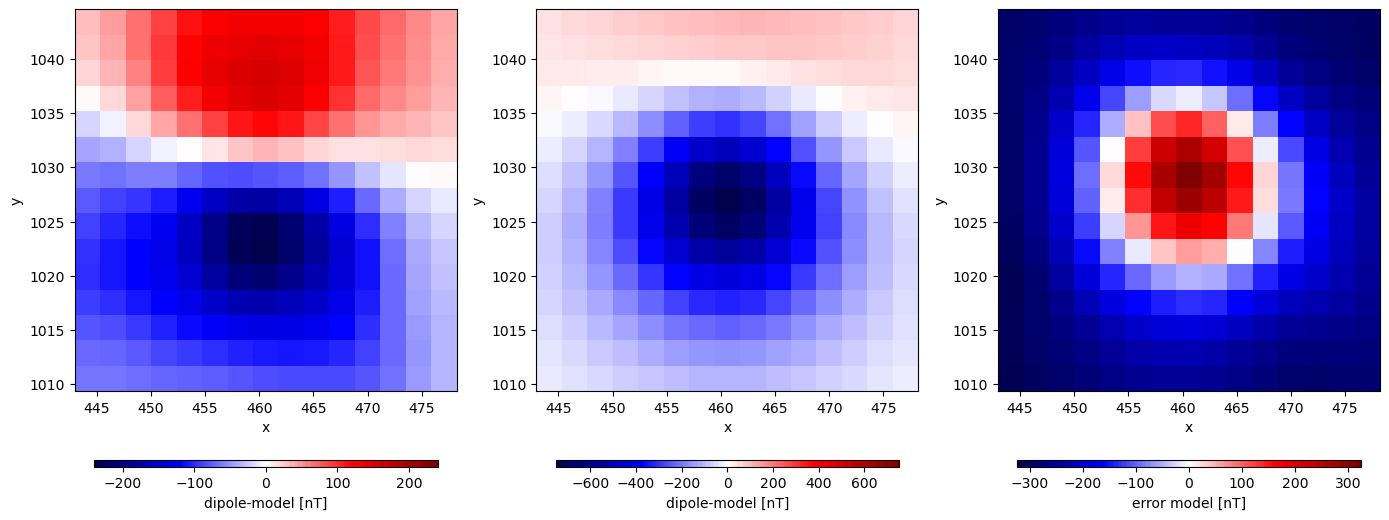

R²: 0.8561122246357772  | Dec: 53.58335732399708 | Inc: -9.302723042175009 | Amp: 7.642961269756665e-14
SNR: 8.769505625462553 |  Xc: 598.7751478997553 |  Yc: 1188.676218914551 |  Zc: -19.660823657982675


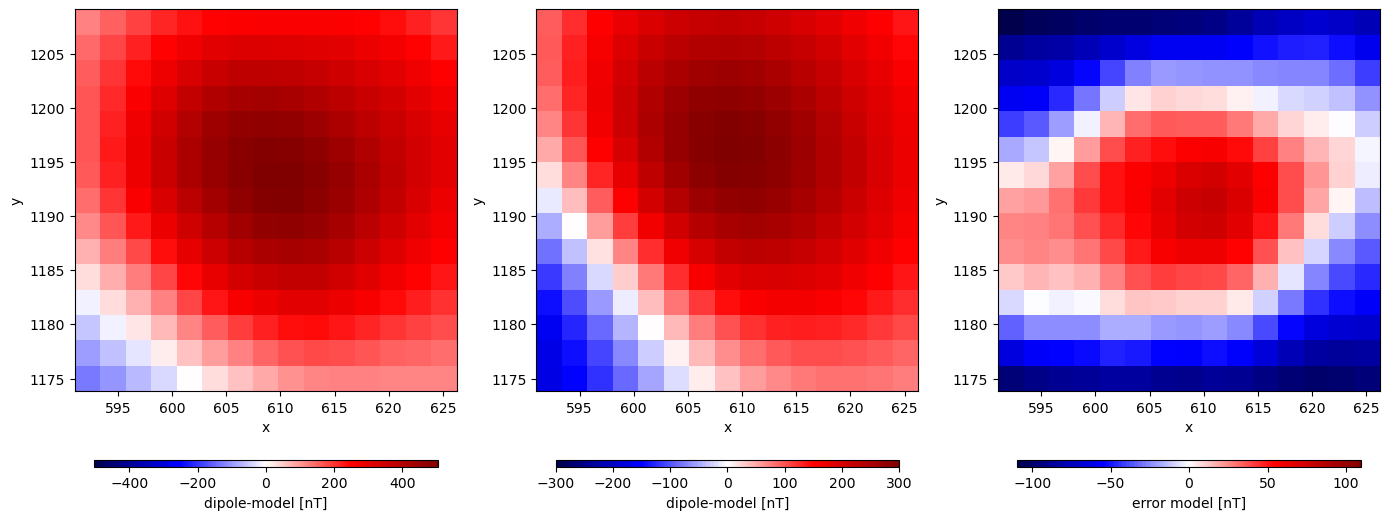

R²: 0.9858628512895431  | Dec: -174.30685855740214 | Inc: -8.217008157369794 | Amp: 1.6606587828358666e-12
SNR: 18.5586478968776 |  Xc: 1039.6588363640954 |  Yc: 931.4442099465839 |  Zc: -46.224300682317626


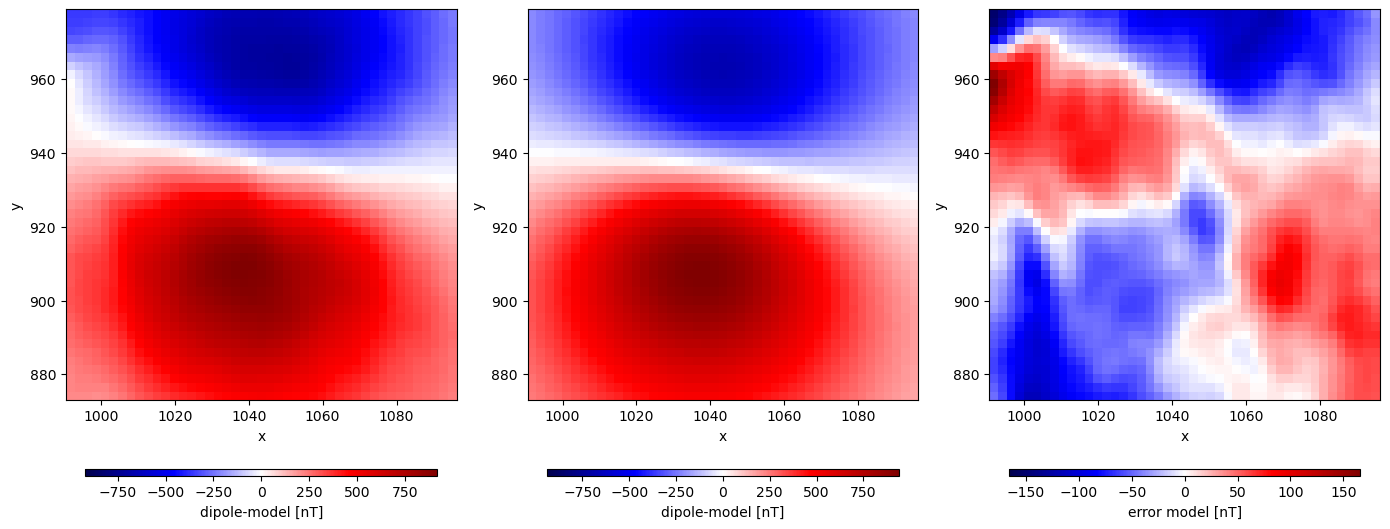

R²: 0.9193040905106905  | Dec: 132.4987956013498 | Inc: -12.157205930119487 | Amp: 3.220302166342803e-15
SNR: 13.875893782634328 |  Xc: 1128.435527180642 |  Yc: 1090.4112876213323 |  Zc: -1.572792615225157


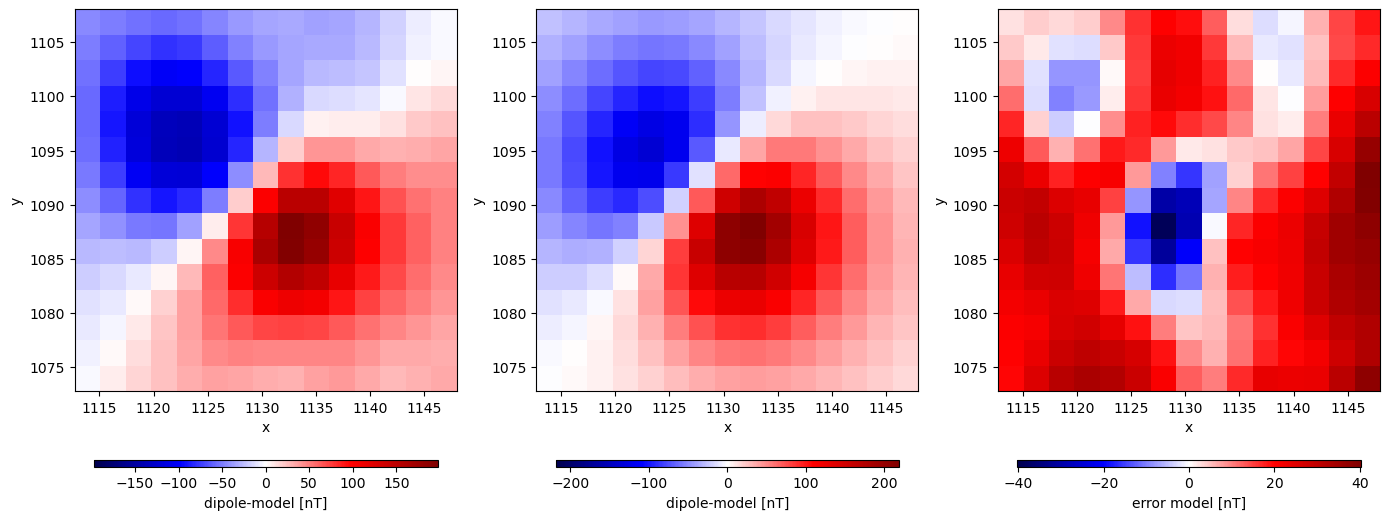

R²: 0.9741854987968206  | Dec: -6.875802266932579 | Inc: -3.0903054233365905 | Amp: 4.335100805714677e-14
SNR: 16.641423032108605 |  Xc: 1989.7217704360119 |  Yc: 738.3715129645145 |  Zc: -12.931246327835114


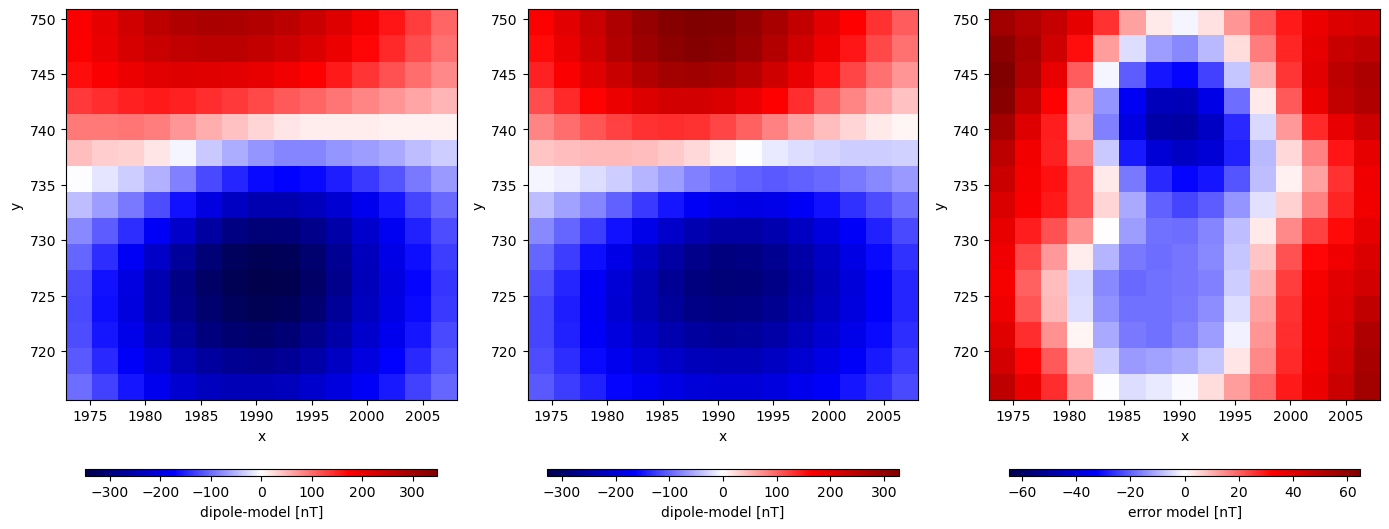

R²: 0.5449665568288551  | Dec: -4.310264614982328 | Inc: 24.85446759163873 | Amp: 7.238824545856414e-14
SNR: 4.293225012543633 |  Xc: 314.25334949612915 |  Yc: 970.3438062323203 |  Zc: -14.291383207339297


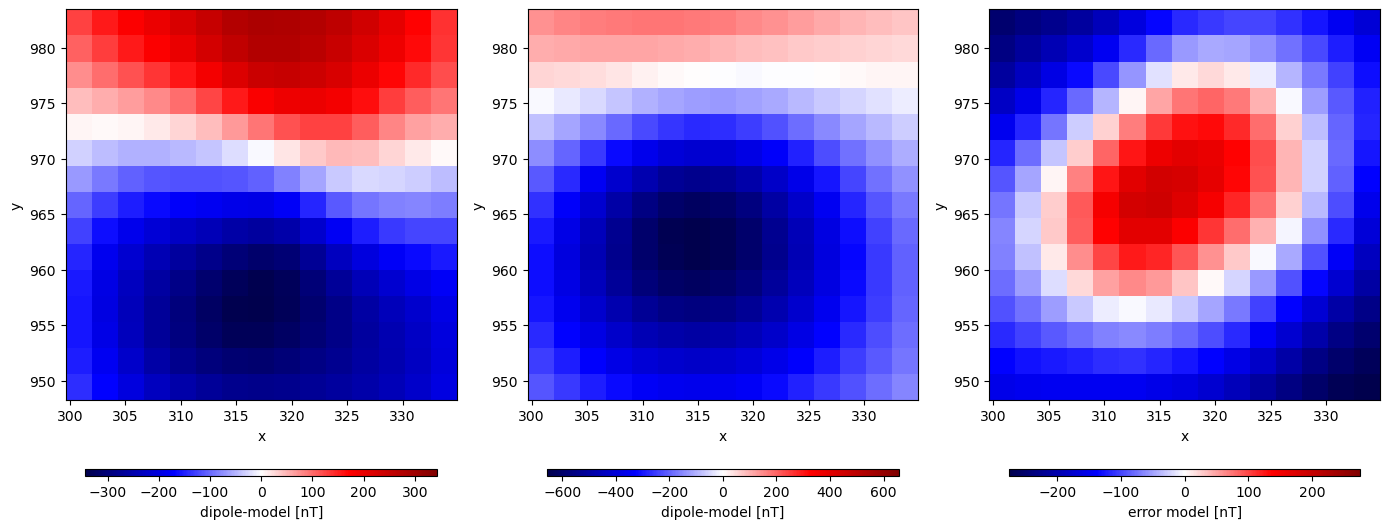

R²: 0.5820117928382271  | Dec: -9.769642997295664 | Inc: -15.457912306518585 | Amp: 1.5440608809340986e-14
SNR: 5.382936189969688 |  Xc: 1573.704297003097 |  Yc: 837.8673246687307 |  Zc: -7.639059935909022


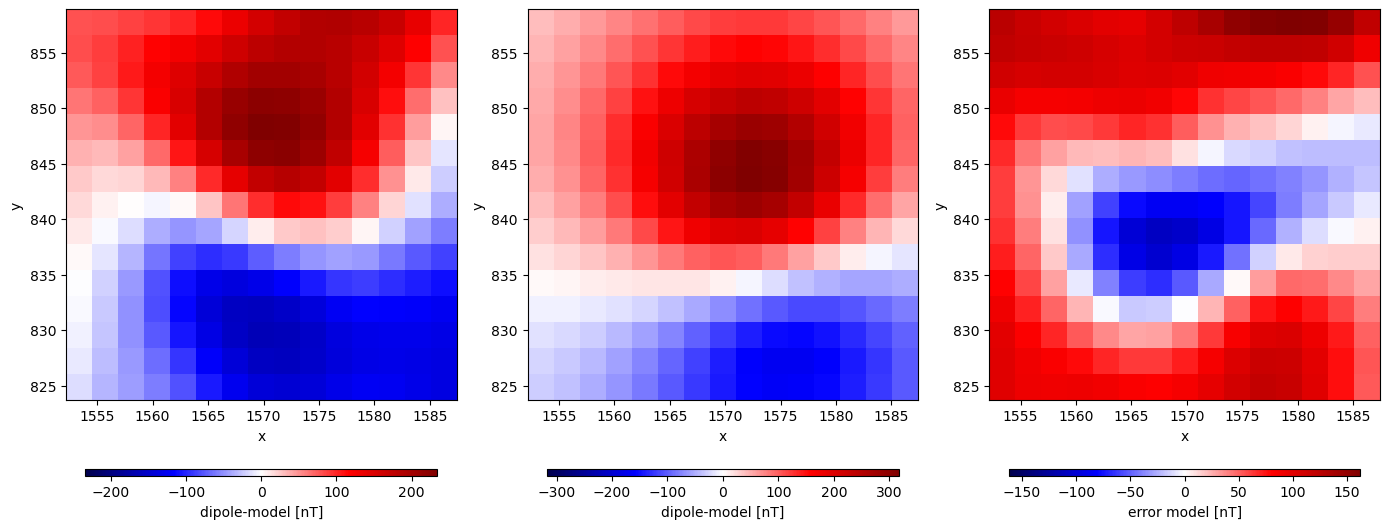

R²: -0.05067358785136222  | Dec: 124.39539345177006 | Inc: 2.5392946440621893 | Amp: 4.122689890229308e-15
SNR: 2.776233392731449 |  Xc: 1224.8471401125619 |  Yc: 153.48465015909346 |  Zc: -5.58472511236956


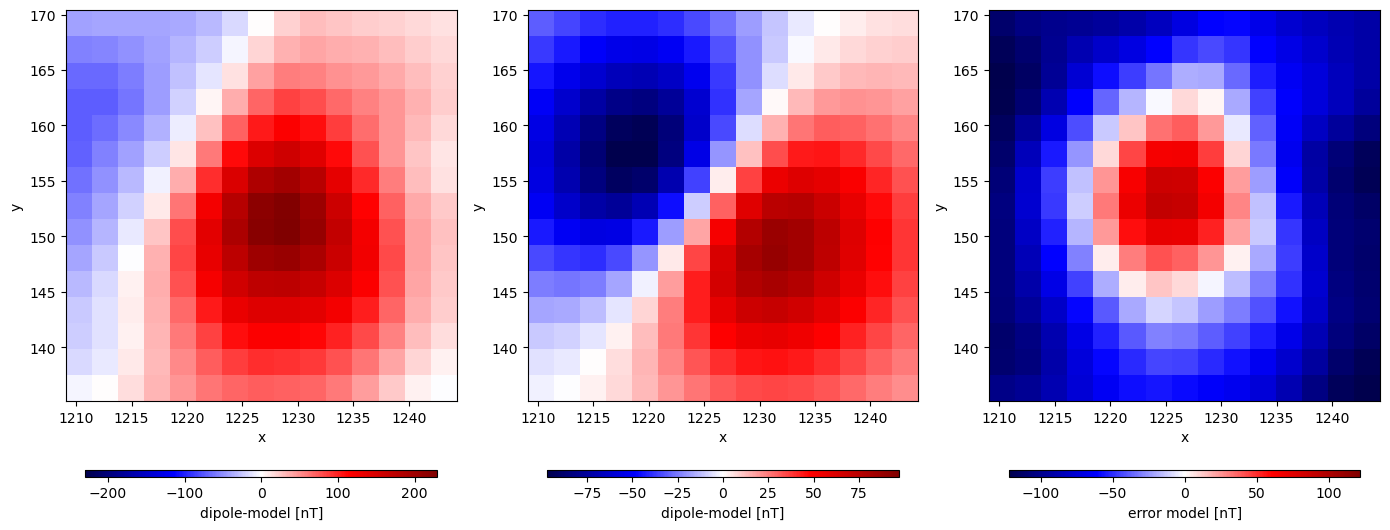

R²: -0.6286167390433823  | Dec: 173.46497856831232 | Inc: 22.64006966768611 | Amp: 2.2739790685210044e-14
SNR: -0.04799379452362616 |  Xc: 597.5807847851303 |  Yc: 1134.3095501779999 |  Zc: -7.6819543248978475


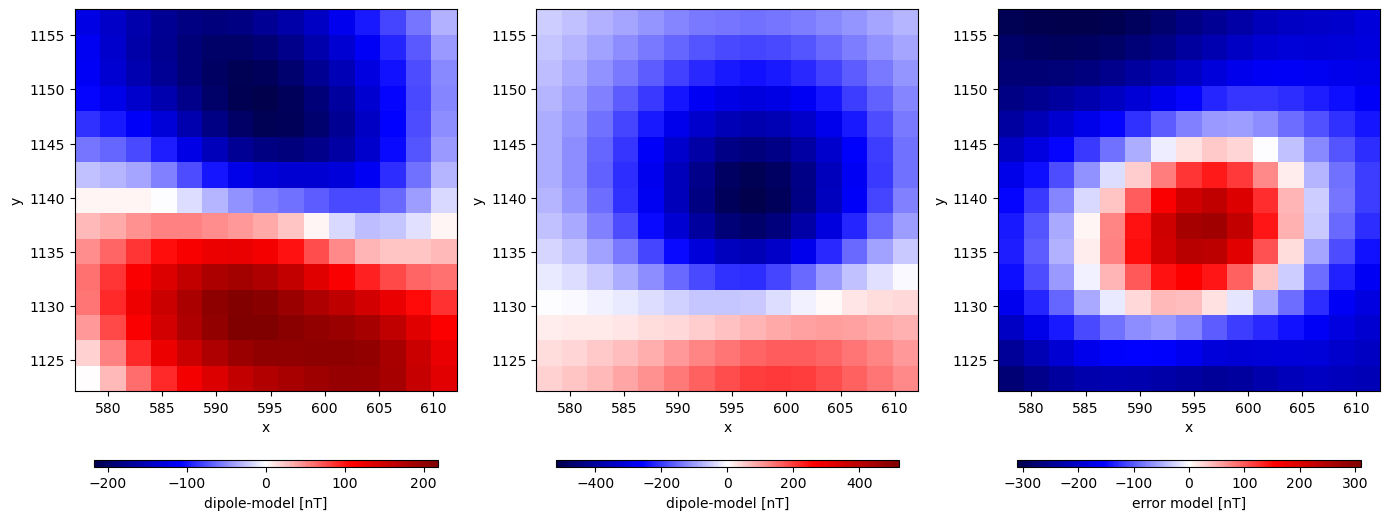

R²: 0.796026810902901  | Dec: -148.6909971141524 | Inc: 3.093348704707338 | Amp: 6.0199220218212525e-15
SNR: 8.153287206273781 |  Xc: 738.2883064984043 |  Yc: 1296.6227872823756 |  Zc: -5.037200760612552


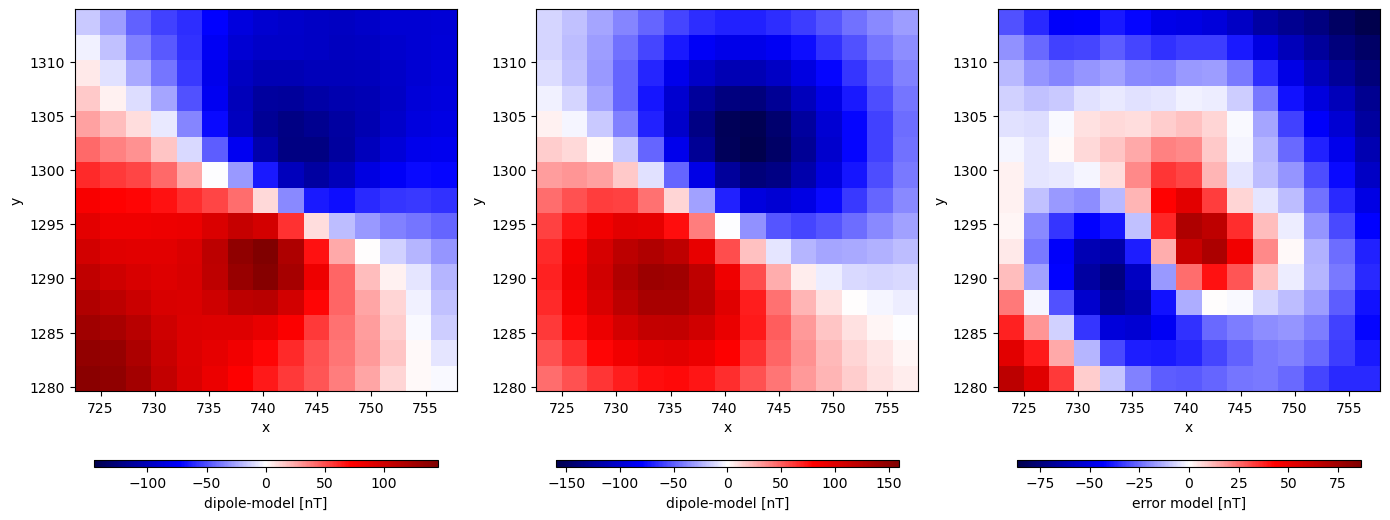

R²: 0.8005653548825384  | Dec: 165.70532884818752 | Inc: -2.2995107066347367 | Amp: 4.1143820775952934e-14
SNR: 8.153239972638739 |  Xc: 1045.0936802399656 |  Yc: 425.9284025330584 |  Zc: -14.005888272472397


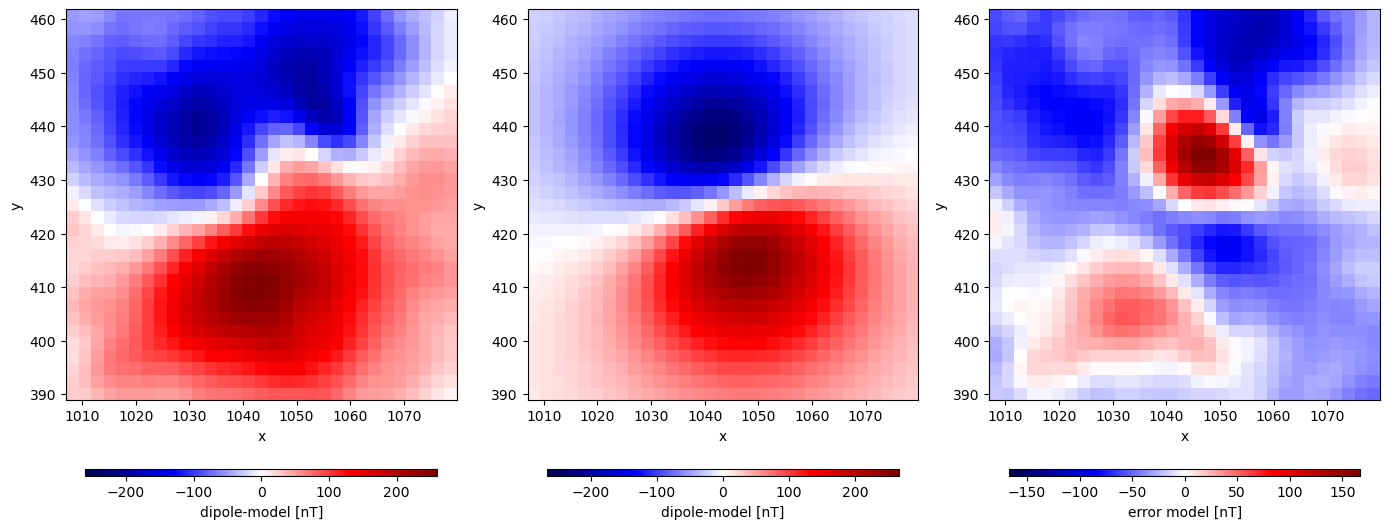

R²: -6.146181703367927  | Dec: 155.27201007347824 | Inc: 49.93519493333491 | Amp: 6.99033421538061e-15
SNR: -4.602173631598259 |  Xc: 814.2303344829326 |  Yc: 901.2285765175033 |  Zc: -4.167757046699569


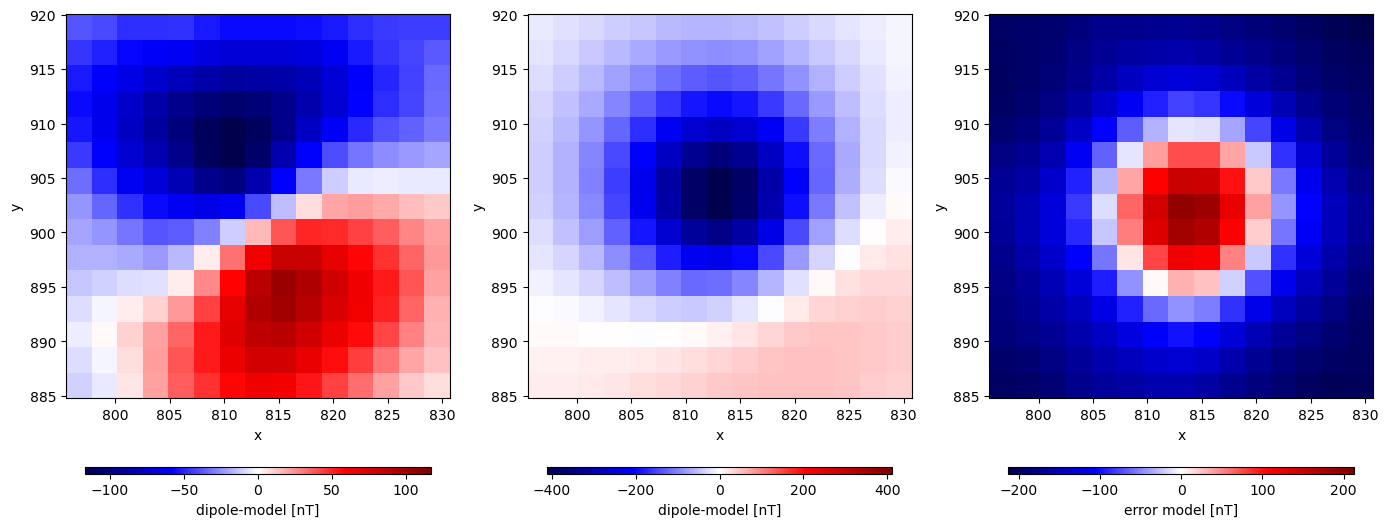

R²: 0.9685133097028229  | Dec: -178.01809108680786 | Inc: 10.092829811748866 | Amp: 1.148720322675305e-13
SNR: 15.032954334398426 |  Xc: 1262.4013658432552 |  Yc: 49.9796099477189 |  Zc: -22.552147837769663


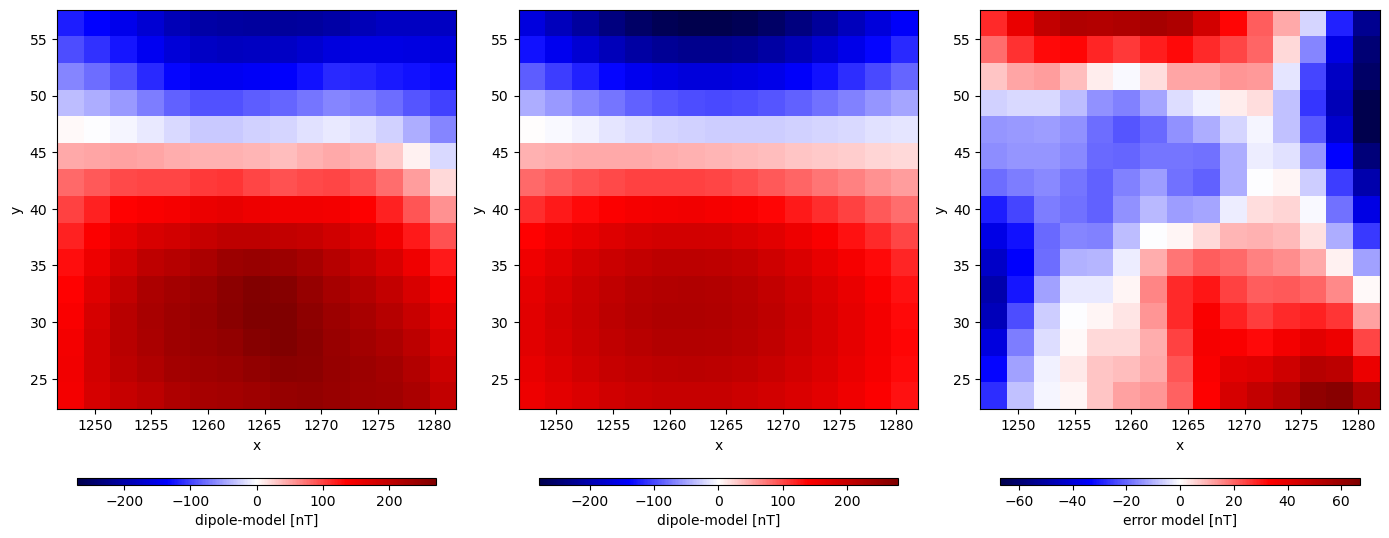

R²: 0.547094540514832  | Dec: 12.749060573212821 | Inc: 19.533211788968142 | Amp: 7.777172473574588e-14
SNR: 6.412096886416679 |  Xc: 838.5622514935167 |  Yc: 1008.3005446940398 |  Zc: -19.59829842221599


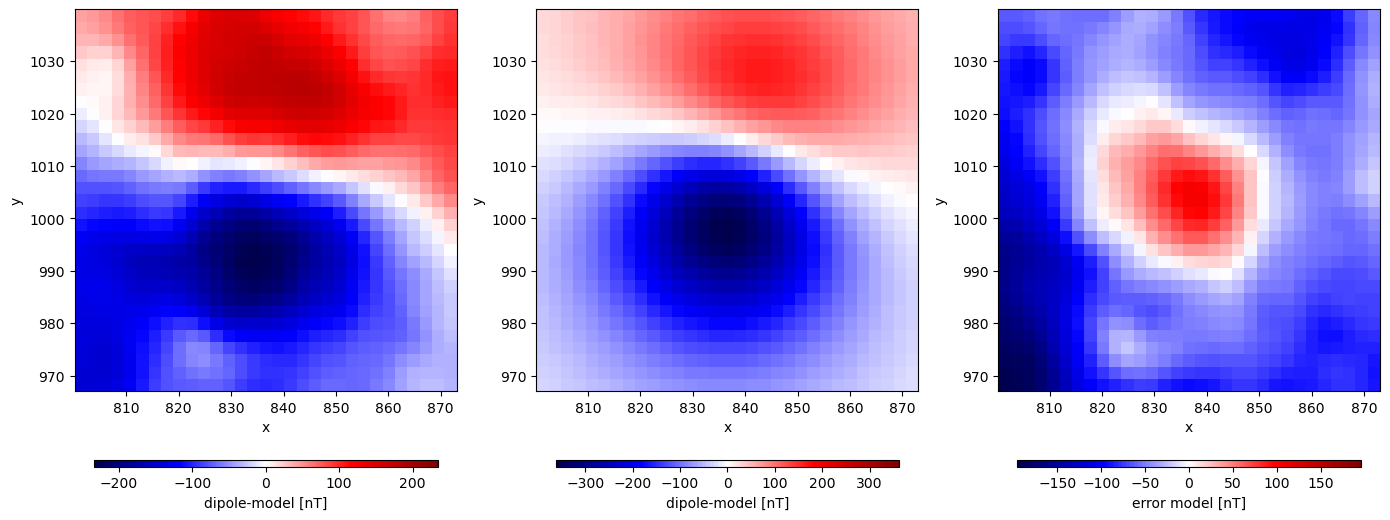

R²: 0.969344839976063  | Dec: -175.0403466015932 | Inc: 24.164519937851516 | Amp: 2.4329259824900213e-13
SNR: 15.321711052543316 |  Xc: 739.805501388269 |  Yc: 516.9231404695207 |  Zc: -18.799574878143385


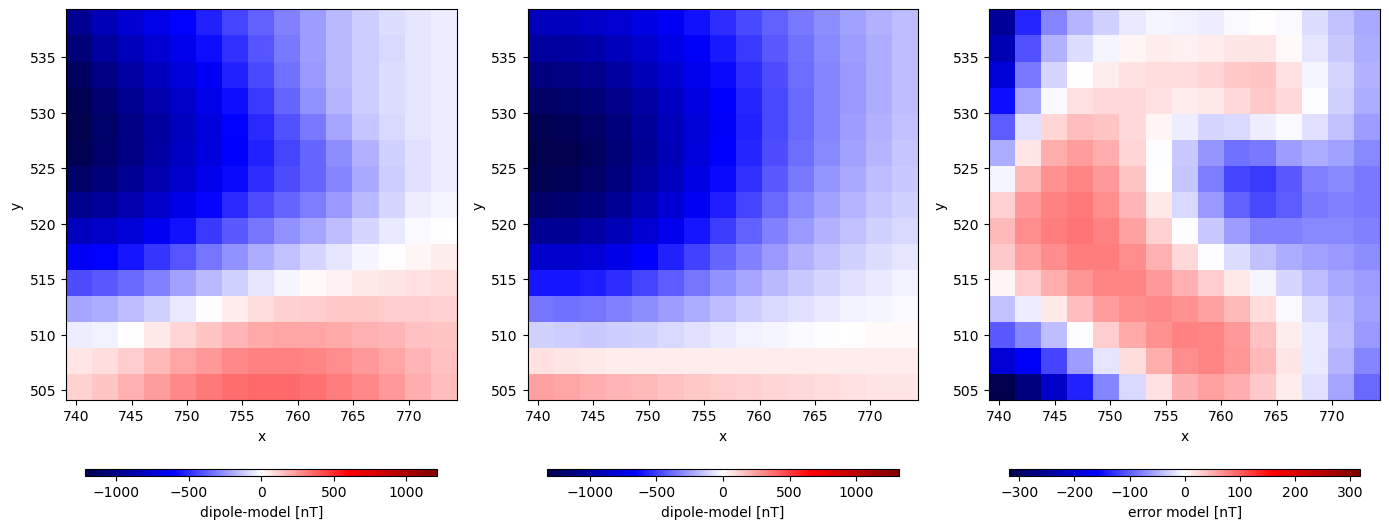

R²: 0.5076598238876993  | Dec: -132.4007999550445 | Inc: -18.19099068959033 | Amp: 2.6453398909447376e-15
SNR: 6.98157836526754 |  Xc: 2086.8844143204183 |  Yc: 827.3757305915993 |  Zc: -2.3325707704303484


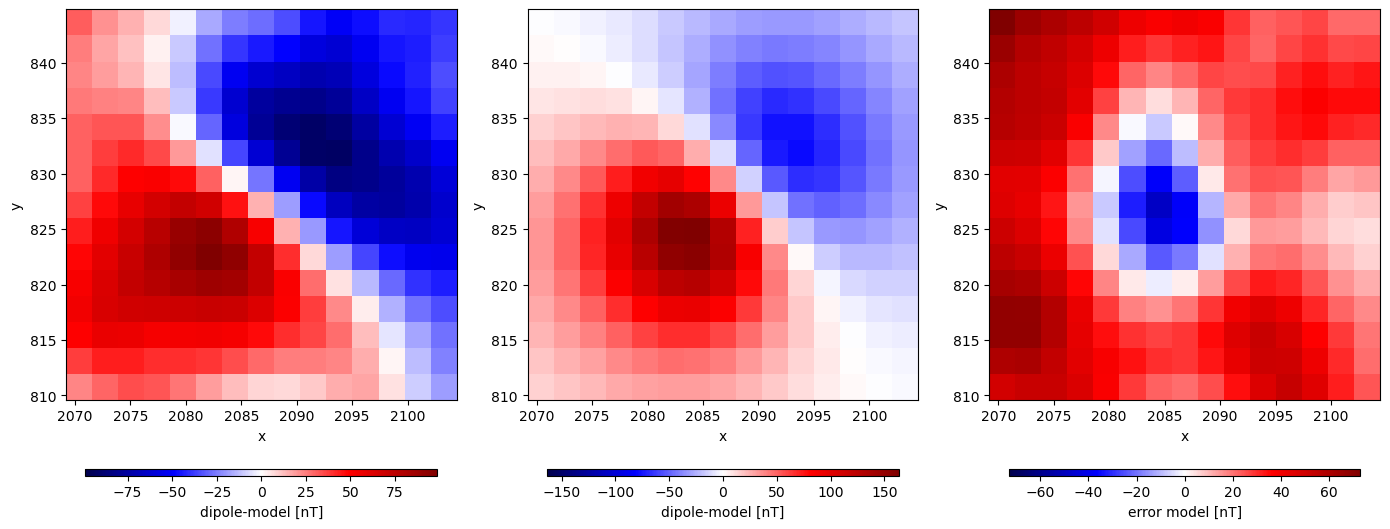

R²: 0.8142375667411543  | Dec: 25.80934967414312 | Inc: -22.468046391038623 | Amp: 3.0280713032998847e-13
SNR: 8.338830680869622 |  Xc: 1327.9953636854702 |  Yc: 294.74271429010724 |  Zc: -33.75482345509722


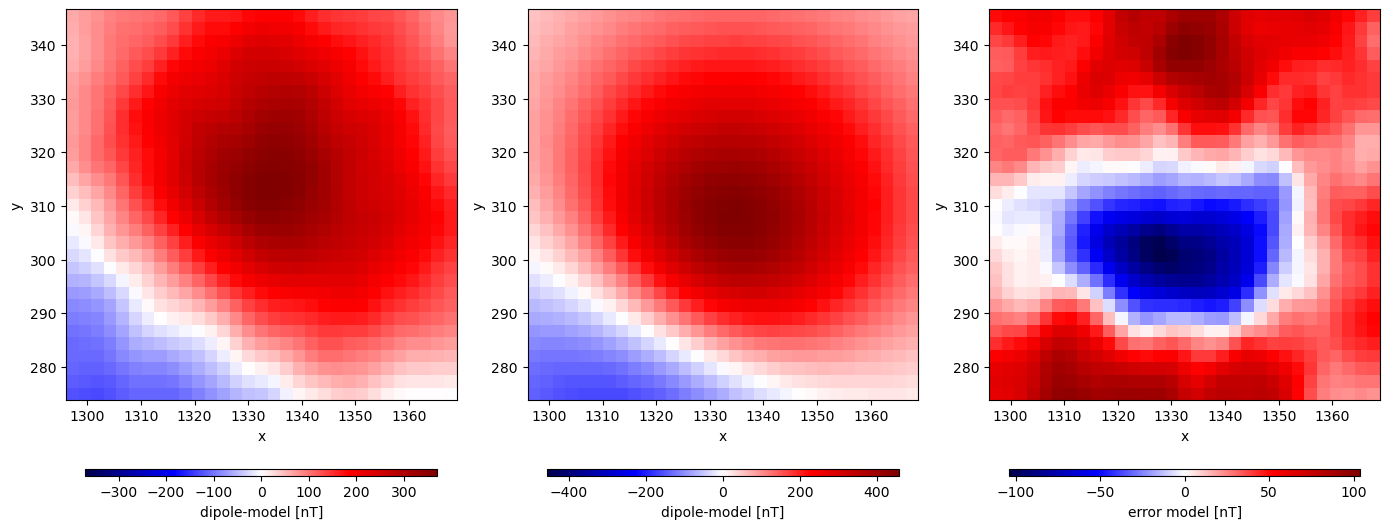

R²: 0.9371790709428276  | Dec: -164.8662523752642 | Inc: -8.121892276259658 | Amp: 4.662620764177854e-12
SNR: 12.494710599055042 |  Xc: 1404.709058272743 |  Yc: 534.8438136826429 |  Zc: -79.11787113564891


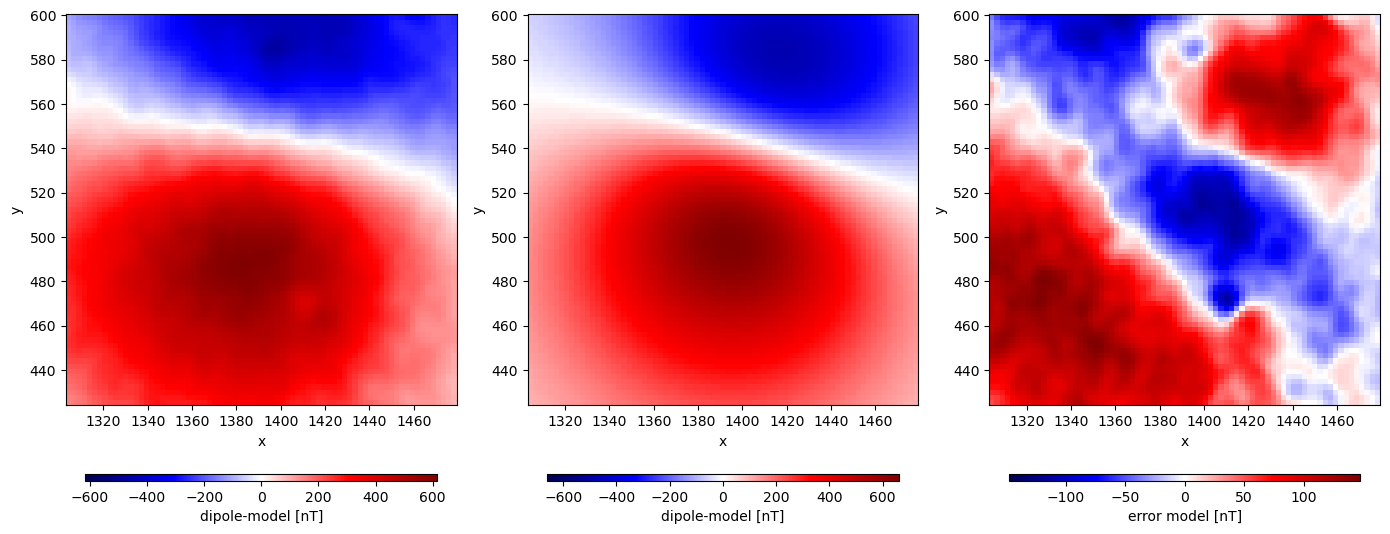

In [495]:
windows_filtered = np.reshape( windows_filtered, (int(np.size(windows_filtered)/4), 4) )
base_level_count = 0
for window, position in zip(windows_filtered, positions.T):
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.bz, position,
    )
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    
    einc, edec, eamp = mg.vector_to_angles(moment)
    print("R²: %s  | Dec: %s | Inc: %s | Amp: %s"%(r2,edec,einc,eamp))
    print("SNR: %s |  Xc: %s |  Yc: %s |  Zc: %s"%(SNR,position[0],position[1],position[2]))
    
    
    # remove background from the window
    data_minus_background = anomaly.bz.values - base_levels[base_level_count]
    base_level_count += 1
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    # calculate model
    coord_slice = vd.grid_coordinates(
    region=[(anomaly.x.values).min(), (anomaly.x.values).max(), (anomaly.y.values).min(), (anomaly.y.values).max()],  # µm
    shape=anomaly.bz.shape,  # µm
    extra_coords=(anomaly.z.values).mean()
    )   
    model = mg.dipole_bz(coord_slice, position, moment)
    

    anomaly = anomaly.assign(model=(['y','x'], model))
    anomaly.model.attrs = {"long_name": "dipole-model", "units": "nT"}

    error = anomaly.bz.values - anomaly.model.values
    anomaly = anomaly.assign(error=(['y','x'],error))
    anomaly.error.attrs = {"long_name": "error model", "units": "nT"}
    
    # plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 14))
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.9)
    for field, ax in zip(["data_minus_background", "model", "error"], axes.ravel()):
        
        anomaly[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    
    for ax in axes.ravel():
        ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

In [496]:
print(base_level_count)

46
